# Piani et al 2023 - ISHS Tatura

&copy; Mirko

***Abstract***


> Red fleshed kiwifruits are a recent entry to the global market, and their nutraceutical properties have garnered significant consumer interest. This produces investment opportunities for industries, which must accurately assess the internal quality of thes e fruits, articularly when faced with long shipping distances and high quality standards. Evaluating the redness of kiwifruit poses a complex challenge due to the inherent variability in colour localization, as well as the wide range of red shades and int ensities within each fruit. The current method employed to assess the colour quality of red fleshed kiwifruit relies on visual inspections performed by experienced operators. However, this method suffers from complexity, subjectivity, limited repeatability, and a slow evaluation process. In this study, a computer vision system that exploits an unsupervised learning algorithm was developed to score fruits according both to red quantity and red quality. RGB images of sliced fruits were segmented into the Hue Saturation Value colour space to generate the RS mask, which was used to extract descriptors for the "red quantity" classifier. Simultaneously, the RS mask was applied to produce a red related image . The "red quality score was determined with a K means clas sifier that assessed the descriptors derived from the conversion of the red related image into the CIELAB color space. Consequently, 102 sample fruits were classified into 36 categories based on the combination of the red quantity and quality scores. The results demonstrated that red color quantity is much more predictable than color quality due to human eye color perception.

In [1]:
# needed libraries and modules
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import confusion_matrix
from IPython.display import clear_output
from sklearn.cluster import KMeans
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from skimage import color
import seaborn as sns
import pandas as pd
import numpy as np
import joblib
import torch
import cv2
import os

In [2]:
# set folder root
os.chdir(os.path.join(os.getcwd(), '..'))
print(f'ROOT: {os.getcwd()}')

ROOT: d:\GITHUB\KiwiSorter


make use of the GPU if available

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'[DEVICE] {device}')

[DEVICE] cuda:0


# Intro

### Visualize the 8-bit HSV color space (OpenCV)

In [4]:
def plot_opencv_hsv_colorspace(V=255):
    '''
    params:
    V: (8bit Scalar) brightness value
    '''
    h_range = np.arange(0, 181, 1)  # H-values range from 0 to 179
    s_range = np.arange(0, 256, 1)  # Reverse S-values from 255 to 0
    h_values, s_values = np.meshgrid(h_range, s_range)
    v_value = V  # Fixed V-value

    # this is an image
    hsv_values = np.stack((h_values, s_values, v_value * np.ones_like(h_values)), axis=-1)
    rgb_values = cv2.cvtColor(hsv_values.astype(np.uint8), cv2.COLOR_HSV2RGB)

    plt.figure(figsize=(10, 5))
    plt.imshow(rgb_values, aspect='auto')  # Set aspect='auto' to maintain the aspect ratio
    plt.text(75, 250, f'Value = {V}', c='w', fontstyle='italic')
    
    plt.xlabel('H Value')
    plt.ylabel('S Value')
    plt.title('HSV Colorspace (8bit)')

In [5]:
def add_point_2_opencv_hsv_colorspace(hs_coord=(5,200), c='k', marker_type='+', msize=5):   
    # Coordinates for the point
    point_coords = hs_coord
    # Plot the point
    plt.scatter(point_coords[0], point_coords[1], color=c, marker=marker_type, s=msize)

In [9]:
def add_lines_2_opencv_hsv_colorspace(hue_val_min=15, hue_val_max=165, text='text here', c='k'):       
    # Coordinates for the line
    line_hue_min = hue_val_min
    line_hue_max = hue_val_max
    # Plot the line
    plt.axvline(x=line_hue_min, color=c, linestyle='--', label=text + f' (min: {hue_val_min} - max: {hue_val_max})')
    plt.axvline(x=line_hue_max, color=c, linestyle='--')
    plt.legend(loc='upper center')

#### HUE to Opencv's hue in 8bit

\
        $Opencv_{HUE} = HUE_{deg} * \frac{179}{360}$

In [6]:
def hue_2_opencv_hue(hue=200):
    return np.asarray([hue*179/360]).astype('uint8')[0]

[Munshell color system](https://babelcolor.com/munsell.htm)


***RED RANGEs***
+ 0 - 30: rossi puri
+ 330 - 360: rossi con sfumature di arancione

In [7]:
# convert HUE 330 in to Opencv Hue
hue_2_opencv_hue(hue=330)

164

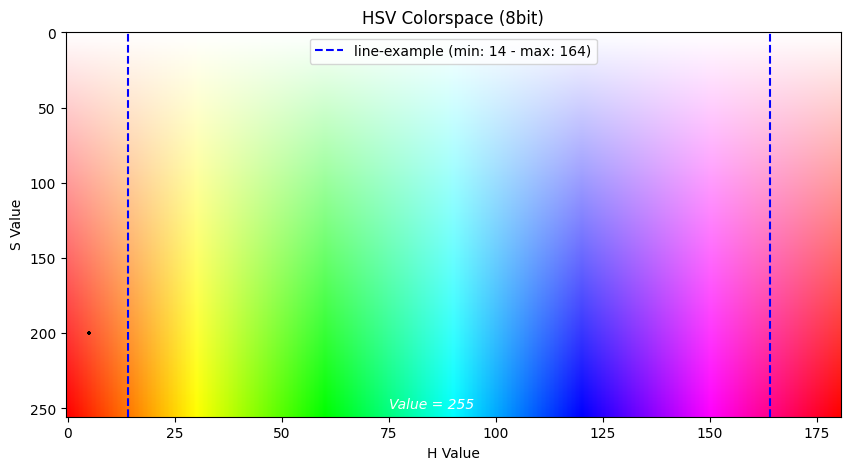

In [10]:
# initialise the plot
plot_opencv_hsv_colorspace()
# add points
add_point_2_opencv_hsv_colorspace()
# add a line with its label
add_lines_2_opencv_hsv_colorspace(hue_val_min=hue_2_opencv_hue(hue=30), 
                                  hue_val_max=hue_2_opencv_hue(hue=330), 
                                  text='line-example', 
                                  c='b')
# show
plt.show()

# Red shades recognition

In [12]:
HOME = os.path.join(os.getcwd(), 'image_database/shades_recognition_db')
# collect file names
images_fpaths = [os.path.join(HOME, fn) for fn in os.listdir(HOME)]
print(f'no. images, N = {len(images_fpaths)}')

no. images, N = 60


### Color labelling

In [5]:
def color_labelling_tool(images_fns, save_data=True):
    ''' This is the HSV color labelling tool
    params:
    images_fns: list of file paths
    save_data: boolean to manage data saving
    '''

    labels = []
    data_list = []
    mean_hsv = []
    
    for i in images_fns:
        # const
        NUM_SAMPLES = 15  # num of samples for each image
        SAMPLE_SIZE = 5  # samples' half dimension (w = SAMPLE_SIZE*2; h = SAMPLE_SIZE * 2)
        DESIRED_LABELS = ['0', '1']  # Negative sample, Positive sample

        im = cv2.imread(i)[:,:,::-1]  # 3-ch RGB Mat 

        # generate random samples
        x_samples = np.random.randint(SAMPLE_SIZE, im.shape[1]-SAMPLE_SIZE, size=NUM_SAMPLES).astype('int')
        y_samples = np.random.randint(SAMPLE_SIZE, im.shape[0]-SAMPLE_SIZE, size=NUM_SAMPLES).astype('int')
        samples = list(zip(x_samples, y_samples))

        for cnt, sample in enumerate(samples):
            x, y = sample 
            # crop Mat at sample coordinates
            fruit_sample = im[y - SAMPLE_SIZE : y + SAMPLE_SIZE, x - SAMPLE_SIZE : x + SAMPLE_SIZE ]
            # convert sample Mat to 8-bit HSV colorspace
            fruit_sample_hsv = cv2.cvtColor(fruit_sample, cv2.COLOR_RGB2HSV)
            # split sample Mat channels 
            h, s, v = cv2.split(fruit_sample_hsv)
            # collect mean values from each channel
            mean_hsv.append((np.mean(h).astype('uint8'),
                            np.mean(s).astype('uint8'),
                            np.mean(v).astype('uint8')))
            
            # visualize the color labelling tool
            fig, ax = plt.subplots(1,2, figsize=(10, 5))
            plt.suptitle('COLOR LABELLING TOOL')
            ax[0].imshow(im)  # RGB image
            ax[0].plot(x , y, 'ks', markersize=10)  # sample coordinates
            ax[1].imshow(fruit_sample)  # RGB sampled matrix

            # add reference colors squares
            ax[1].plot(0, 0, 'sk', markersize=50)
            ax[1].plot(SAMPLE_SIZE*1.92, SAMPLE_SIZE*1.92, 'sr', markersize=50)
            ax[1].plot(0, SAMPLE_SIZE*1.92, 'sg', markersize=50)
            ax[1].plot(SAMPLE_SIZE*1.92, 0, 'sw', markersize=50)

            # manage axis
            ax[0].set_xticks([])
            ax[0].set_yticks([])
            ax[1].set_xlim(0, SAMPLE_SIZE*1.92)
            ax[1].set_ylim(0, SAMPLE_SIZE*1.92)
            ax[1].set_xticks([])
            ax[1].set_yticks([])
            plt.show()
            
            # labelling
            inp = ''
            while inp not in DESIRED_LABELS:
                inp = input()
            
            labels.append(int(inp))
            data_list.append(f'{i}_s{cnt}')

            # clear the tool visualiation at each sampledel
            clear_output(wait=True)

    if save_data == True:    
        data = {'image':data_list, 'label':labels, 'HSV': mean_hsv}
        df = pd.DataFrame(data)

        # save the sampled data
        df.to_csv(os.path.join(os.getcwd(), 'data/sampled_shades.csv'), index=False) 
        print('\sampled_shades.csv saved!')

    return df



## run the tool
#color_labelling_tool(images_fpaths, save_data=False)

Parse the output dataset

In [ ]:
def parse_sampled_dataframe(fpath=''):
    '''
    parsing unwanted strings in the data
    params:
        fpath: path to raw labelling dataframe
        return: parsed dataframe
    '''

    # 0 : Negative sample  |  1: Positive sample
    hsv_df = pd.read_csv(fpath, sep=',')
    # remove unnecessary data
    hsv_df = hsv_df.drop(['image'], axis=1)

    h = []
    s = []
    v = []

    temp = hsv_df.HSV

    for cnt, hsv_coord in enumerate(temp):
         col = hsv_coord.split('(')
         col = col[1].split(')')[0]
         h_coord, s_coord, v_coord = col.split(',')
        
         h.append(h_coord)
         s.append(s_coord)
         v.append(v_coord)

    # create H,S,V cols
    hsv_df['h'] = h
    hsv_df['s'] = s
    hsv_df['v'] = v

    # drop orginial coords
    hsv_df = hsv_df.drop(['HSV'], axis=1)

    # change dtype
    hsv_df.h = hsv_df.h.astype('int')
    hsv_df.s = hsv_df.s.astype('int')
    hsv_df.v = hsv_df.v.astype('int')

    hsv_df.to_csv(fpath, index=False)

    return hsv_df


# hsv_dataset = parse_sampled_dataframe(fpath=os.path.join(os.getcwd(), 'data/sampled_shades.csv'))

**Dataset visualization**

In [13]:
hsv_dataset = pd.read_csv(os.path.join(os.getcwd(), 'data/sampled_shades.csv'), sep=',')
display(hsv_dataset.head(5))

,label,h,s,v
0,0,26,89,239
1,0,27,102,244
2,0,27,69,228
3,0,26,90,239
4,0,25,82,240


Assessing data unbalance

In [14]:
raw_count = hsv_dataset.groupby('label')['label'].count()
raw_count

label
0    576
1    324
Name: label, dtype: int64

Visualizing raw data

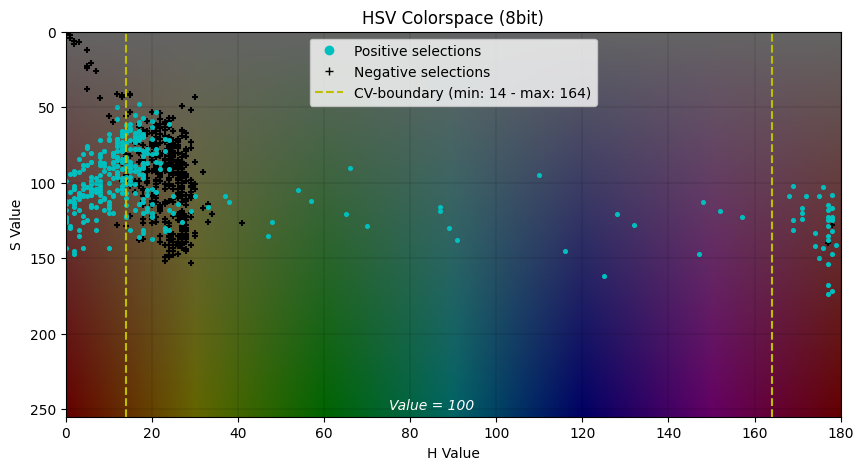

In [15]:
# initialise the plot
plot_opencv_hsv_colorspace(V=100)

# add samples to legend
plt.plot(0, 280, 'co', label='Positive selections')
plt.plot(0, 280, 'k+', label='Negative selections')

# add a lines with boundaries labels
add_lines_2_opencv_hsv_colorspace(hue_val_min=hue_2_opencv_hue(hue=30), 
                                  hue_val_max=hue_2_opencv_hue(hue=330), 
                                  text='CV-boundary', 
                                  c='y')

# add sample points
for idx, row in hsv_dataset.loc[hsv_dataset.label==0].iterrows():
    # add points
    h = row.h
    s = row.s
    add_point_2_opencv_hsv_colorspace(hs_coord=(h,s), c='k', marker_type='+', msize=15)

for idx, row in hsv_dataset.loc[hsv_dataset.label==1].iterrows():
    # add points
    h = row.h
    s = row.s
    add_point_2_opencv_hsv_colorspace(hs_coord=(h,s), c='c', marker_type='o', msize=7)


    
plt.xlim([0, 180])
plt.ylim([255, 0])
plt.grid(lw=.1, color='k')

# show
images_dir = os.path.join(os.getcwd(), 'images')
os.makedirs(images_dir, exist_ok=True)
plt.savefig(os.path.join(images_dir, 'ISHS_hsv_dataset_raw_samples.png'), dpi=400)
plt.show()

Data cleaning

In [ ]:
# filtering by H
hsv_dataset = hsv_dataset.loc[(hsv_dataset.h <= 35) | (hsv_dataset.h >= 140)]
hsv_dataset

,label,h,s,v
0,0,26,89,239
1,0,27,102,244
2,0,27,69,228
3,0,26,90,239
4,0,25,82,240
...,...,...,...,...
895,0,0,0,255
896,1,11,108,246
897,1,4,101,217
898,0,0,0,255


Verify cleaning

In [ ]:
clean_count = hsv_dataset.groupby('label')['label'].count()
diff = raw_count[0] - clean_count[1]

print(f'removed data are:\n{raw_count - clean_count}')


removed data are:
label
0     1
1    18
Name: label, dtype: int64


### Thresholds identification
Hue boundaries

In [ ]:
print('Sorting Boundary min: {}'.format(hsv_dataset.loc[(hsv_dataset.label==1)&(hsv_dataset.h < 100)].h.max()))
print('Sorting Boundary max: {}'.format(hsv_dataset.loc[(hsv_dataset.label==1)&(hsv_dataset.h > 100)].h.min()))

Sorting Boundary min: 33
Sorting Boundary max: 147


In [ ]:
print('Sorting Boundary (Negative selctions) min: {}'.format(hsv_dataset.loc[(hsv_dataset.label==0)&(hsv_dataset.h < 100)].h.max()))
print('Sorting Boundary (Negative selctions) max: {}'.format(hsv_dataset.loc[(hsv_dataset.label==0)&(hsv_dataset.h > 100)].h.min()))

Sorting Boundary (Negative selctions) min: 34
Sorting Boundary (Negative selctions) max: 177


#### thresholds identification
+ Lower computer vision boundary ($L_{CV}$) = 14
+ Upper computer vision boundary ($L_{CV}$) = 164

+ Sorting_boundary_Positive_samples_min = 33
+ Sorting_boundary_Negative_samples_min = 34

\
thus:

+ $L_{SB}$ = $L_{CV}$ + (34-14)/2 = 24
+ $U_{SB}$ = 147

#### Saturation boundaries

In [ ]:
print('Sorting Boundary min S: {}'.format(hsv_dataset.loc[(hsv_dataset.label==1)&(hsv_dataset.h < 100)].s.min()))
print('Sorting Boundary max S: {}'.format(hsv_dataset.loc[(hsv_dataset.label==1)&(hsv_dataset.h > 100)].s.max()))

Sorting Boundary min S: 48
Sorting Boundary max S: 174


In [ ]:
print('Sorting Boundary min V: {}'.format(hsv_dataset.loc[(hsv_dataset.label==1)&(hsv_dataset.h < 100)].v.min()))
print('Sorting Boundary max V: {}'.format(hsv_dataset.loc[(hsv_dataset.label==1)&(hsv_dataset.h > 100)].v.max()))

Sorting Boundary min V: 126
Sorting Boundary max V: 225


Visualizing the thresholds difference

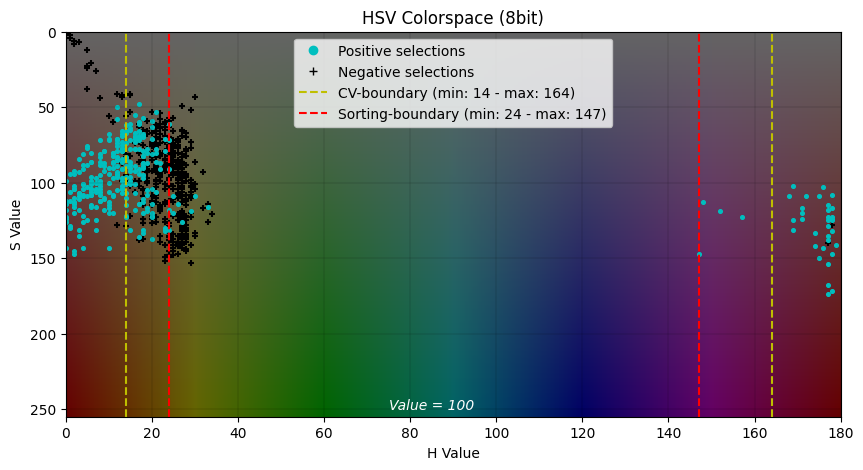

In [ ]:
# initialise the plot
plot_opencv_hsv_colorspace(V=100)

# add samples to legend
plt.plot(0, 280, 'co', label='Positive selections')
plt.plot(0, 280, 'k+', label='Negative selections')

# add a lines with boundaries labels
add_lines_2_opencv_hsv_colorspace(hue_val_min=hue_2_opencv_hue(hue=30), 
                                  hue_val_max=hue_2_opencv_hue(hue=330), 
                                  text='CV-boundary', 
                                  c='y')

add_lines_2_opencv_hsv_colorspace(hue_val_min=24, 
                                  hue_val_max=147, 
                                  text='Sorting-boundary', 
                                  c='r')

# add sample points
for idx, row in hsv_dataset.loc[hsv_dataset.label==0].iterrows():
    # add points
    h = row.h
    s = row.s
    add_point_2_opencv_hsv_colorspace(hs_coord=(h,s), c='k', marker_type='+', msize=15)

for idx, row in hsv_dataset.loc[hsv_dataset.label==1].iterrows():
    # add points
    h = row.h
    s = row.s
    add_point_2_opencv_hsv_colorspace(hs_coord=(h,s), c='c', marker_type='o', msize=7)

    
plt.xlim([0, 180])
plt.ylim([255, 0])
plt.grid(lw=.1, color='k')

# show
images_dir = os.path.join(os.getcwd(), 'images')
os.makedirs(images_dir, exist_ok=True)
plt.savefig(os.path.join(images_dir, 'ISHS_hsv_dataset.png'), dpi=400)
plt.show()

### Functions to apply the thresholds to images

Clarification
> + `cv_segmenter()` function applies classical computer vision thresholds for red segmentation ($L_{CV}$, $U_{CV}$)
> + `image_segmenter()` function applies the thresholds identified through color labelling ($L_{SB}$, $U_{SB}$)

In [4]:
def cv_segmenter(cv2_im_mtx):
    ''' Applies red segmentation to fruit images '''
    # ensure the required data type 
    cv2_im_mtx = cv2_im_mtx.astype('uint8')
    # change bkg color to green
    mask = np.all(cv2_im_mtx == [255, 255, 255], axis=2)
    cv2_im_mtx[mask] = [0, 255, 0]
    # change colorspace ang get hue channel
    hue = cv2.cvtColor(cv2_im_mtx, cv2.COLOR_BGR2HSV)[:,:,0] # 0-179 since it is int8 array
    # segment for red
    red_mtx = np.where((hue>=0)&(hue<=14)|(hue>=164), 1, 0)  # (0-15) | (>170)
    return red_mtx.astype('uint8')

In [5]:
def image_segmenter(cv2_im_mtx):
    ''' Applies red shades recognition to fruit images (cv2_im_mtx)'''
    L_CV = 14  # lower computer vision bound
    U_CV = 164  # upper computer vision bound
    L_SB = 22  # lower sorting bound
    U_SB = 147  # upper sorting bound

    # ensure the required data type 
    cv2_im_mtx = cv2_im_mtx.astype('uint8')
    
    # changing colorspace
    hue = cv2.cvtColor(cv2_im_mtx, cv2.COLOR_BGR2HSV) # 0-179 since it is int8 array
    
    # get hue color angle
    h, s, v = cv2.split(hue)
    
    # computer vision boundaries
    red_hue_cv = np.where( (((h >= 0) & (h <= L_CV))|(h >= U_CV)) 
                      & (s > 50) 
                      & ((v > 50) & (v < 253)),
                      1,
                      0)
    
    # sorting boundaries
    sat_condition = np.where(
        ((h <= L_SB) & (h > L_CV)),
        50 + (h - L_CV).astype('int') * int(100/ (L_SB - L_CV )),
        150 - (h - U_CV).astype('int') * int(100/ (U_CV - U_SB ))
    )

    red_hue_sb_lower = np.where(
        ((h > L_CV) & (h <= L_SB)) &
        (s > sat_condition) & ((v > 50)&(v < 253)),  #  100 perchè tra hue 20 e 40 abbiamo il marrone
        1,
        0
    )
    
    red_hue_sb_upper = np.where(
        ((h >= U_SB) & (h <= U_CV)) &
        (s > sat_condition) & ((v > 50) & (v < 253)),
        1,
        0
    )
  
    red_mtx = red_hue_sb_lower + red_hue_sb_upper + red_hue_cv  
    return red_mtx.astype('uint8')

The below function identifies the pixels containing background color (== white)

In [6]:
def bkg(im_mtx_bgr):
    ''' removes white background from fruit images (cv2_im_mtx)'''
    # TODO: does it make sense to give directly Fmask?
    im_gray = cv2.cvtColor(im_mtx_bgr, cv2.COLOR_BGR2GRAY)
    return np.where(im_gray == 255, 1, 0).astype('int8')

### Image resizing
It has the purpose of:
+ speeding up the processing speed
+ normalize for fruit size variations

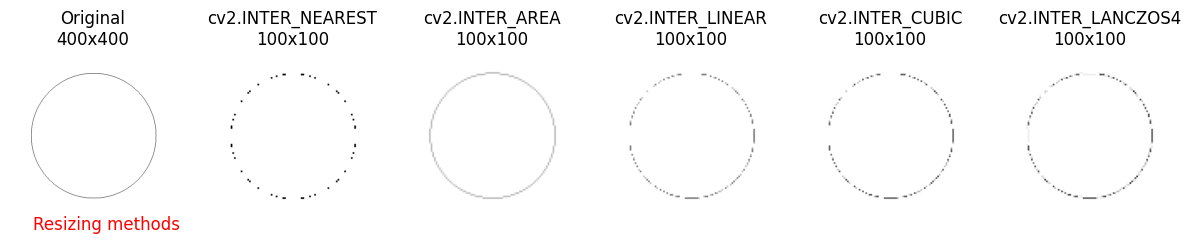

In [18]:
# Generate a white background
original_image = np.ones((400, 400, 3), dtype=np.uint8) * 255

# Create a black circle
center = (200, 200)
radius = 150
c = (0, 0, 0)
cv2.circle(original_image, center, radius, c, 1)  # 1 PIXEL WIDTH


# Resize using different methods
methods = [
    ("cv2.INTER_NEAREST", cv2.INTER_NEAREST),
    ("cv2.INTER_AREA", cv2.INTER_AREA),
    ("cv2.INTER_LINEAR", cv2.INTER_LINEAR),
    ("cv2.INTER_CUBIC", cv2.INTER_CUBIC),
    ("cv2.INTER_LANCZOS4", cv2.INTER_LANCZOS4),
]

# Create a figure with a circular layout
num_methods = len(methods)
theta = np.linspace(0, 2 * np.pi, num_methods, endpoint=False)
radius = 5
x = radius * np.cos(theta)
y = radius * np.sin(theta)

fig, axs = plt.subplots(1, num_methods + 1, figsize=(15, 5))
fig.text(0.14, 0.3, "Resizing methods", color='red', fontsize=12, ha='left', va='bottom')

# Plot the original image with a label
axs[0].imshow(original_image)
axs[0].set_title(f"Original\n{original_image.shape[1]}x{original_image.shape[0]}")
axs[0].axis("off")

# Loop over resize methods
for i, (method_name, method) in enumerate(methods):
    resized_image = cv2.resize(original_image, (100, 100), interpolation=method)
    axs[i + 1].imshow(resized_image)
    axs[i + 1].set_title(f"{method_name}\n{resized_image.shape[1]}x{resized_image.shape[0]}")
    axs[i + 1].axis("off")


plt.show()

image resizing is made with `cv2.INTER_AREA` interpolation to keep as much as possible the fruit details

### sample applications

Giallo A1 (1-5) 0,0,0_FRUIT_ID_1_s_0.png


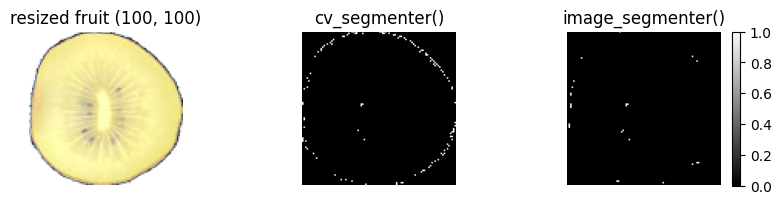

Rosso B1 (1-5) 1,1,0_FRUIT_ID_1_s_1.png


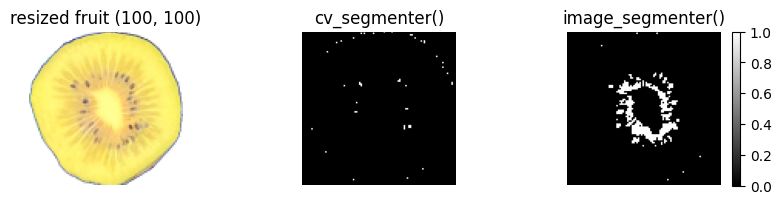

Pre-harvest a (1-6)_FRUIT_ID_5_s_2.png


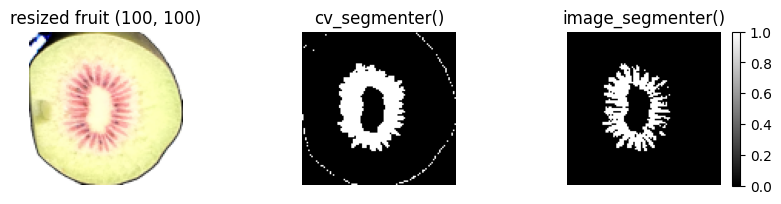

Pre-harvest a (1-6)_FRUIT_ID_1_s_3.png


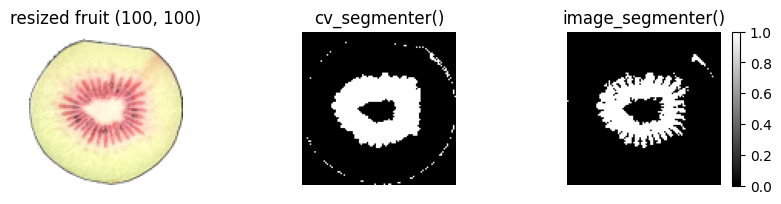

T0 4 (25-32)_FRUIT_ID_1_s_4.png


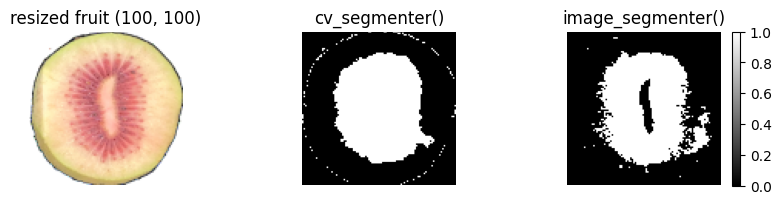

T1 A3 (17-25) exp 1_FRUIT_ID_1_s_5.png


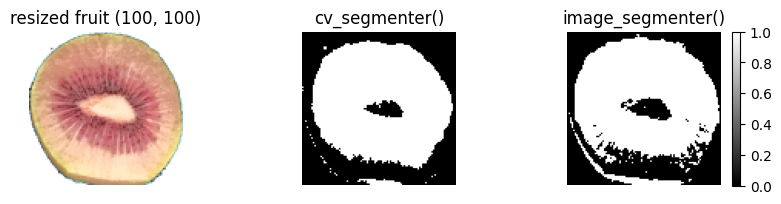

In [ ]:
HOME = os.path.join(os.getcwd(), 'image_database/q_db')

locators = []
predictors = []
idx = 0
for path, subdirs, files in os.walk(HOME):
    for file in files[0:1]:
        if file.endswith('.png'):
            print(file)
            # open the image file
            im = cv2.imread(path + '\\' + file)
            im = cv2.resize(im, (100,100), interpolation= cv2.INTER_AREA)
            
            out = cv_segmenter(im)
            out_imp = image_segmenter(im)
            
            fig, ax = plt.subplots(1,3, figsize=(10,2))
            ax[0].set_title('resized fruit (100, 100)')
            ax[0].imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
            ax[0].axis('off')

            ax[1].set_title('cv_segmenter()')
            ax[1].imshow(out, cmap='gray')  
            ax[1].axis('off')

            ax[2].set_title('image_segmenter()')
            im = ax[2].imshow(out_imp, cmap='gray') 
            plt.colorbar(im, ax=ax[2])
            ax[2].axis('off')
            plt.show()
    idx +=1

# Red quantity ($q$)

### Visualizing the main data extraction steps

Giallo A1 (1-5) 0,0,0_FRUIT_ID_1_s_0.png


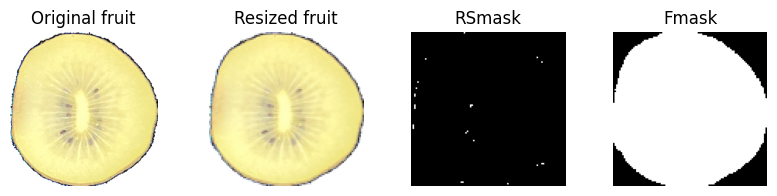

Rosso B1 (1-5) 1,1,0_FRUIT_ID_1_s_1.png


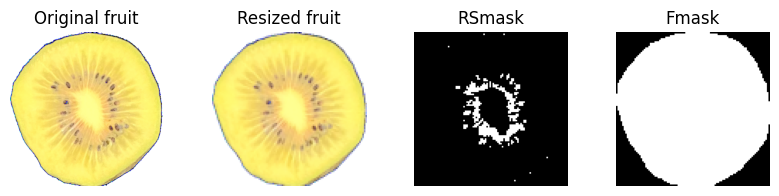

Pre-harvest a (1-6)_FRUIT_ID_5_s_2.png


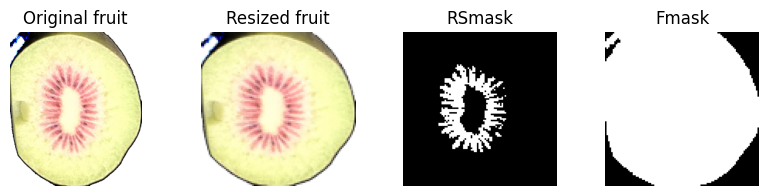

Pre-harvest a (1-6)_FRUIT_ID_1_s_3.png


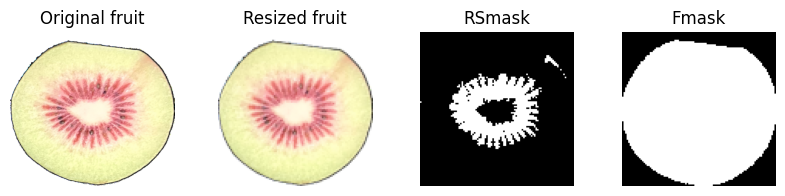

T0 4 (25-32)_FRUIT_ID_1_s_4.png


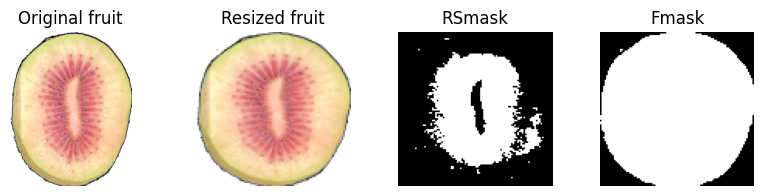

T1 A3 (17-25) exp 1_FRUIT_ID_1_s_5.png


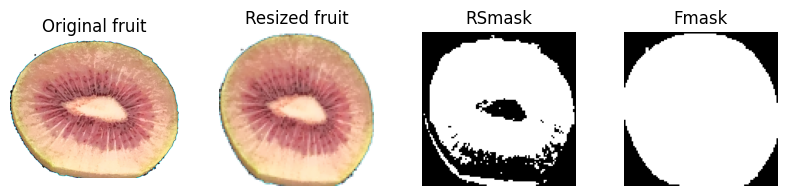

In [10]:
HOME = os.path.join(os.getcwd(), 'image_database/q_db')

for path, subdirs, files in os.walk(HOME):
    for file in files[0:1]:
        if file.endswith('.png'):
            print(file)
            # open the image file
            im_raw = cv2.imread(path + '\\' + file)
            im = cv2.resize(im_raw, (100,100), interpolation= cv2.INTER_AREA)
            
            hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
            
            rs_mask = image_segmenter(im)
            # get fruit and background pixels count
            bkg_mtx = bkg(im) 
            f_mask = 1 - bkg_mtx
            
            rgb_out = cv2.bitwise_and(im[:,:,::-1], im[:,:,::-1], mask=rs_mask)
            cielab_out = cv2.cvtColor(rgb_out, cv2.COLOR_RGB2LAB)
            
            fig, ax = plt.subplots(1,4, figsize=(10,2))
            ax[0].set_title('Original fruit')
            ax[0].imshow(cv2.cvtColor(im_raw, cv2.COLOR_BGR2RGB))
            ax[0].axis('off')
            
            ax[1].set_title('Resized fruit')
            ax[1].imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
            ax[1].axis('off')

            ax[2].set_title('RSmask')
            ax[2].imshow(rs_mask, cmap='gray')  
            ax[2].axis('off')
            
            ax[3].set_title('Fmask')
            ax[3].imshow(f_mask, cmap='gray')
            ax[3].axis('off')

            plt.show()

### Data extraction

In [8]:
# unbalanced red quantity dataset
HOME = os.path.join(os.getcwd(), 'image_database/q_db')

# dir of the balanced dataset 
PATH = os.path.join(os.getcwd(), 'image_database/red_quantity_db_ISHS')
os.makedirs(PATH, exist_ok=True)

# regenerate RED_QUANITYT_DB dataset or not
REGENERATE = False

quantity_predictors = []
# list to store right score
score_q = []

cnt = 0
for path, subdirs, files in os.walk(HOME):
    # define training files  
    for file in files[0:10]:
        if file.endswith('.png'):
            print('{}/{} : {}'.format(cnt + 1, 10*6, file))
            # open the image file
            im = cv2.imread(path + '\\' + file) # BGR
            # save image in red_quantity_db
            if REGENERATE == True:
                cv2.imwrite(f'{PATH}/{file}', im)
                print(f'image saved at: {PATH}/{file}')
            
            # make image standardized in size to take into account the fruit size variations
            im = cv2.resize(im, (100,100), interpolation= cv2.INTER_AREA)
            
            # get fruit and background pixels count
            bkg_mtx = bkg(im)  # function to segment the background 
            f_mask = 1 - bkg_mtx
            fruit_pixels = np.sum(f_mask)
            
            # segmentation of red shades
            rs_mask = image_segmenter(im)
            
            ## get descriptors
            frp = (np.sum(rs_mask)/fruit_pixels)  # red percentage over fruit pixels
            mv = np.mean(rs_mask)  # mean value
            print(f'({frp= }, {mv= })\n')
           
            # export quantity and quality predictors
            quantity_predictors.append((frp, mv))
            score_q.append(int(file[-5:-4]))
            
            cnt += 1

1/60 : Giallo A1 (1-5) 0,0,0_FRUIT_ID_1_s_0.png
(frp= 0.0032047331443362504, mv= 0.0026)

2/60 : Giallo A1 (1-5) 0,0,0_FRUIT_ID_2_s_0.png
(frp= 0.0093994140625, mv= 0.0077)

3/60 : Giallo A1 (1-5) 0,0,0_FRUIT_ID_3_s_0.png
(frp= 0.0032528462404604027, mv= 0.0026)

4/60 : Giallo A1 (1-5) 0,0,0_FRUIT_ID_4_s_0.png
(frp= 0.00487012987012987, mv= 0.0039)

5/60 : Giallo A1 (1-5) 0,0,0_FRUIT_ID_5_s_0.png
(frp= 0.003902914989632882, mv= 0.0032)

6/60 : Giallo A2 (6-10) 0,0,0_FRUIT_ID_1_s_0.png
(frp= 0.00395873320537428, mv= 0.0033)

7/60 : Giallo A2 (6-10) 0,0,0_FRUIT_ID_2_s_0.png
(frp= 0.009602363658746768, mv= 0.0078)

8/60 : Giallo A2 (6-10) 0,0,0_FRUIT_ID_3_s_0.png
(frp= 0.005151551455612795, mv= 0.0043)

9/60 : Giallo A2 (6-10) 0,0,0_FRUIT_ID_4_s_0.png
(frp= 0.0024292481476982874, mv= 0.002)

10/60 : Giallo A2 (6-10) 0,0,0_FRUIT_ID_5_s_0.png
(frp= 0.014646053702196907, mv= 0.0126)

11/60 : Rosso B1 (1-5) 1,1,0_FRUIT_ID_1_s_1.png
(frp= 0.07334525939177101, mv= 0.0574)

12/60 : Rosso B1 (1-5

Checking that train classes are equally represented

In [9]:
# count the number of fruit per each red quanityt class in 'red_quantity_db_ISHS'
class_counts = {i:score_q.count(i) for i in set(score_q)}

for ind, val in enumerate(class_counts):
    print(f'q: {val} -- samples count {class_counts[val]}')

q: 0 -- samples count 10
q: 1 -- samples count 10
q: 2 -- samples count 10
q: 3 -- samples count 10
q: 4 -- samples count 10
q: 5 -- samples count 10


In [10]:
frp =[]  # 1st quantity predictor
mv =[]  # 2nd quantity predictor
df = pd.DataFrame()  # empty dataframe

for i, val in enumerate(quantity_predictors):
    frp.append(val[0])
    mv.append(val[1])

df['frp'] = frp
df['mv'] = mv

# zip descriptors
quantity_predictors = list(zip(frp, mv))  # over-write the object

# save the dataframe
dfs_dir = os.path.join(os.getcwd(), 'data')
os.makedirs(dfs_dir, exist_ok=True)

#df.to_csv(os.path.join(dfs_dir, '2023_09_15_predictors_red_quantity.csv'), index=False)

In [11]:
print(f'Sample data (frp, mv): {quantity_predictors[0]}')

Sample data (frp, mv): (0.0032047331443362504, 0.0026)


### *q_clf*

#### Design and train

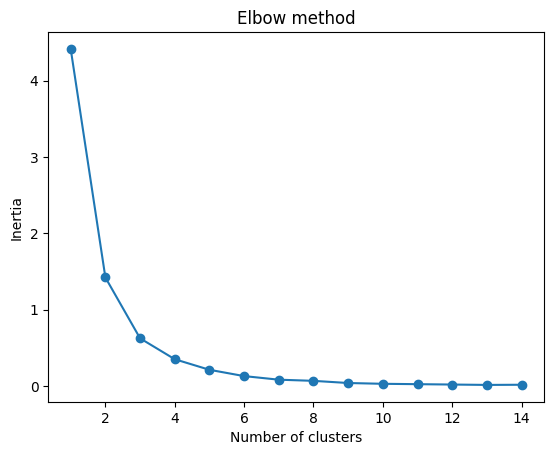

In [ ]:
inertias = []
for i in range(1,15):
    kmeans = KMeans(n_clusters=i, n_init='auto')
    kmeans.fit(quantity_predictors)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,15), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=6)  # design
kmeans.fit(quantity_predictors)  # train

## export a new model
# models_dir = os.path.join(os.getcwd(), 'models')
# os.makedirs(models_dir, exist_ok=True)
# joblib.dump(kmeans,  os.path.join(models_dir, 'q_clf.pkl'))

#### Predictions

In [3]:
# load the pretrained model
q_clf = joblib.load(os.path.join(os.getcwd(), 'models\q_clf.pkl') , mmap_mode ='r')

In [12]:
# make predictions
pred = q_clf.predict(quantity_predictors)  # 'quantity_predictors' is generated in the data extraction section

print(f'sample data (frp, mv): {quantity_predictors[0:1]}')
print(f'sample pred (cluster): {pred[0:1]}')

sample data (frp, mv): [(0.0032047331443362504, 0.0026)]
sample pred (cluster): [0]


In [13]:
x1_frp = []  # list of 1st predictor: fruit red percentage [0-1] 
x2_mv = []  # list of 2nd predictor: bbox mean value [0-1] 
q_pred_clust = []  # list of preditions

for i in quantity_predictors:
    x1_frp.append(i[0])
    x2_mv.append(i[1])
    # append the predicted cluster for each indexed predictor element
    q_pred_clust.append(pred[quantity_predictors.index(i)])

In [14]:
print('frp\n{}\n'.format(x1_frp[0:5]))
print('mv\n{}\n'.format(x2_mv[0:5]))
print('pred clust\n{}'.format(q_pred_clust[0:5]))

frp
[0.0032047331443362504, 0.0093994140625, 0.0032528462404604027, 0.00487012987012987, 0.003902914989632882]

mv
[0.0026, 0.0077, 0.0026, 0.0039, 0.0032]

pred clust
[0, 0, 0, 0, 0]


The code below wants to re-label the clusters according to increasing *frp* and *mv*

Clusters:
(0.024167556602375406, 0.019371428571428595, 0)
(0.582423301526314, 0.47524, 1)
(0.3266901875540205, 0.2693058823529412, 2)
(0.7668661112671393, 0.6435666666666666, 3)
(0.16719805330390503, 0.136025, 4)
(0.4525845920406814, 0.37043333333333334, 5)

q_pred classes - centroid coordinate
(0.024167556602375406, 0.019371428571428595, 0)
(0.16719805330390503, 0.136025, 4)
(0.3266901875540205, 0.2693058823529412, 2)
(0.4525845920406814, 0.37043333333333334, 5)
(0.582423301526314, 0.47524, 1)
(0.7668661112671393, 0.6435666666666666, 3)

remapped_index= {0: 0, 4: 1, 2: 2, 5: 3, 1: 4, 3: 5}


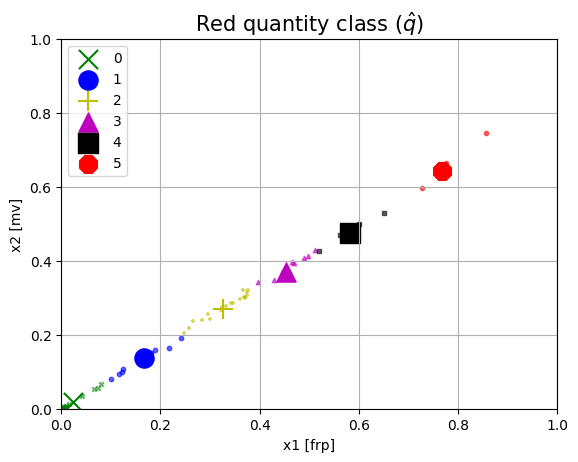

In [23]:
# Get the centroids (x, y) from trained model
centroids = q_clf.cluster_centers_

# get cluster labels
c_lab = q_clf.labels_
labs = list(np.unique(c_lab))

# assembling centroids and labels
centers = []
for ind, val in enumerate(centroids): 
    label = labs[ind]
    centers.append((val[0], val[1], label))

print('Clusters:')
for i in centers:
    print(i)

# sort centroid centers and labels according to increasing frp and mv (elements in pos: 0 and 1)
sorted_clusters= sorted(centers, key=lambda x: (x[0], x[1]))

# use a dictionary to remap clusters into real world labels
remapped_index = dict()
## -- WHAT IS IT -- 'remapped_index'
# the 'remapped_index' contains positioning data which are used to
# remap the predicted cluster into real world classes:
# for example:
# remapped_index = [0, 2, 4, 3, 5, 1]
# prediction = 2   
# ---> real_world_score = remapped_index.index(prediction)
# ---> real_world_score = 1  # index of element 2

# the labels are now sorted and remapped, 
# thus the remapped label with index 0 is the one with the lowest red quantity,
# on the other side, the one with index 5 has the highest
print('\nq_pred classes - centroid coordinate')
for ind, cluster in enumerate(sorted_clusters):
    print(cluster)
    remapped_index[cluster[2]] = ind  # cluster: class
print(f'\n{remapped_index= }')

# define custom colors and markers
colors = ['g','b','y','m','k','r']
m = ['x','o', '+', '^', 's', '8']

# plot fruit data (11 fruits per each class)
for i in range(0,len(x1_frp)): 
    plt.scatter(x1_frp[i], x2_mv[i], 
                    c=colors[remapped_index[q_pred_clust[i]]], 
                    s=10, 
                    marker=m[remapped_index[q_pred_clust[i]]],
                    alpha=.6)

# plot clusters centroids
for i in range(0, len(centers)):
        plt.scatter(centers[i][0], centers[i][1], 
                    marker=m[remapped_index[centers[i][2]]], 
                    c=colors[remapped_index[centers[i][2]]], 
                    s=190, 
                    label=remapped_index[centers[i][2]])

# sort plot legend
# get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# sort the labels in the legend and place in on the top left corner
plt.legend([handles[idx] for idx in remapped_index],
           [labels[idx] for idx in remapped_index],
          loc='upper left') 


plt.title('Red quantity class ($\hat{q}$)', fontsize=15)
plt.ylabel('x2 [mv]')
plt.xlabel('x1 [frp]')
plt.xlim([0,1])
plt.ylim([0,1])
plt.grid()

images_dir = os.path.join(os.getcwd(), 'images')
os.makedirs(images_dir, exist_ok=True)
plt.savefig(os.path.join(images_dir, 'kmeans_Piani_et_al_2023_IEEE.png'), dpi=400)

plt.show()

Checking predictions unbalance with respect to the reference class

q: 0 -- samples count 10 | predictions count 14
q: 1 -- samples count 10 | predictions count 9
q: 2 -- samples count 10 | predictions count 19
q: 3 -- samples count 10 | predictions count 9
q: 4 -- samples count 10 | predictions count 6
q: 5 -- samples count 10 | predictions count 3


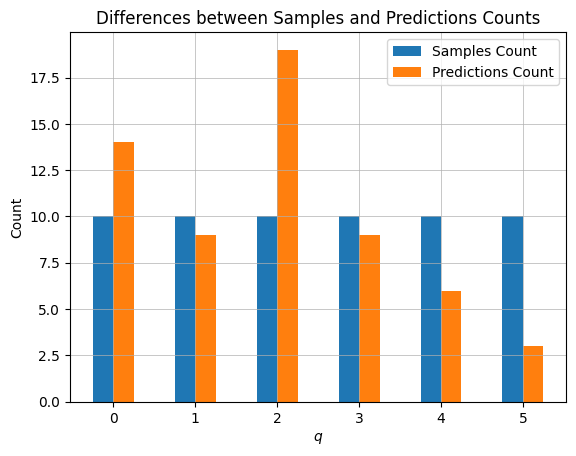

In [24]:
# count the number of fruit per each red quantity class
class_counts_ref = {i:score_q.count(i) for i in set(score_q)}
# apply remapping
remapped_q = [remapped_index[i] for i in q_pred_clust]
class_counts_pred = {i:remapped_q.count(i) for i in set(remapped_q)}

for ind, val in enumerate(class_counts_ref):
    print(f'q: {val} -- samples count {class_counts_ref[val]} | predictions count {class_counts_pred[val]}')


# Plot the differences as a barplot
categories = list(class_counts_ref.keys())
samples_count = [class_counts_ref[val] for val in categories]
predictions_count = [class_counts_pred[val] for val in categories]

fig, ax = plt.subplots()
ax.grid(lw=.5)
bar_width = 0.25
index = range(len(categories))

bar1 = ax.bar(index, samples_count, bar_width, label='Samples Count')
bar2 = ax.bar([i + bar_width for i in index], predictions_count, bar_width, label='Predictions Count')

ax.set_xlabel('$q$')
ax.set_ylabel('Count')
ax.set_title('Differences between Samples and Predictions Counts')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(categories)
ax.legend()

plt.show()


### correlation test

The code below has the purpose of:
* writing a dataset containing info about `image`, `fruit` (Scalar), `predictor 1`, `predictor 2` where predictors are *frp* - fruit red percentage and *mv* - mean mask value
* add to that dataset the reference attribute quantity score (`q_ref`) to be compared with the predicted one (`q_pred`) computed starting from the predictors
* calculate the correlation matrix to test *Pearson correlation (r)* among predictors, predictors - target score, predicted score - target score

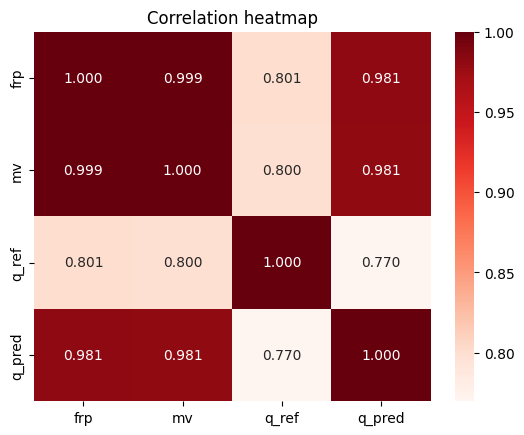

In [25]:
# init the dataset
df = pd.DataFrame(columns=['image', 'fruit', 'frp', 'mv', 'q_ref'])

# inti list
frp = []
mv = []

for i in quantity_predictors:  # data = list(zip(predictor_1, predictor_2))
    # add data to list
    frp.append(i[0])
    mv.append(i[1])

# add predictors to the dataset
df['frp'] = frp
df['mv'] = mv


# process the same images to get other info
HOME = os.path.join(os.getcwd(), 'image_database/red_quantity_db_ISHS')


list_images = []
list_fruit_id = []

for path, subdirs, files in os.walk(HOME):
    # loop over traning fruits
    for file in files:
        if file.endswith('.png'):
            t = '_FRUIT_ID_'
            # get original image name
            image = file[0:file.find(t)]
            # get fruit id
            id_fruit = file[file.find(t) + len(t) : file.find(t) + len(t) + 2]
            # append data to lists
            list_images.append(image)
            list_fruit_id.append(id_fruit)

# add info to the dataset
df['image'] = list_images
df['fruit'] = list_fruit_id
# transform str column into int
df['fruit'] = df["fruit"].str.replace("_","").astype('uint8')

# loop over the dataset to create the image complete filename (with file format)
for idx, row in df.iterrows():
    df.iloc[idx,0] = row['image']+'.JPG'


# import another dataset with complete fruit evaluations
dfs_dir = os.path.join(os.getcwd(), 'data')
os.makedirs(dfs_dir, exist_ok=True)
df1 = pd.read_csv(os.path.join(dfs_dir, 'initial_rater_dataset.csv'), sep=';')  # open dataset with full evaluations


# list to host Red quantity data
r_quantity = []
for idx, row in df.iterrows():
    df.iloc[idx,0] = row['image']
    # complete data with evaluations copied
    df_eval = df1.copy()
    # dataset filtering to get data about fruit id in a specific image
    df_eval = df_eval.loc[(df_eval['image'] == row.image) & (df_eval['FRUIT_ID'] == row.fruit)]
    # append red quantity info to its list
    r_quantity.append(df_eval['q'].values)
    
# process red quantity data
s = [q for q in r_quantity]

# red quantity score
rq = []
for score in s:
    rq.append(str(score))
# process list of arrays into a list of values
red_q_scores =  [i[1] for i in rq]

# add the dataset with an additional column named q_ref
df['q_ref'] = red_q_scores

# remove characters
df = df.loc[(df.q_ref != '[')]
df = df.loc[(df.q_ref != ']')]

df.q_ref = df.q_ref.astype('uint8')


# create a columns to host predicted scores
df['q_pred'] = 0

# score predictions based on preditor1 and preditor2
for idx, row in df.iterrows():
    x1 = float(row['frp'])
    x2 = float(row['mv'])
    # prediction
    pred = q_clf.predict([[x1, x2]])
    
    # remap the cluster and append it to the target column
    df.loc[idx, 'q_pred'] = remapped_index[int(pred)]

## --- CORRELATION TEST --- ##
# the test has to define if predictors have Pearson correlation with the target variable

# remove categorical data
df = df.drop(['fruit', 'image'], axis=1)

# Mask the lower triangle of the correlation matrix
mask = np.triu(np.ones_like(df.corr(), dtype=bool))

# Plot the heatmap
# sns.heatmap(df.corr(), cmap="Reds", annot=True, fmt=".2f", mask=mask)  # mask half of the matrix
sns.heatmap(df.corr(), cmap="Reds", annot=True, fmt=".3f")  # whole matrix

plt.title('Correlation heatmap')

# save figure
images_dir = os.path.join(os.getcwd(), 'images')
os.makedirs(images_dir, exist_ok=True)
plt.savefig(os.path.join(images_dir, 'heatmap_corr_red_quantity_Piani_et_al_2023_ISHS.png'), dpi=400)
plt.show()

# Red Intensity ($i_1, i_2$)

### Visualizing the main data extraction steps

Giallo A1 (1-5) 0,0,0_FRUIT_ID_1_i_0.png


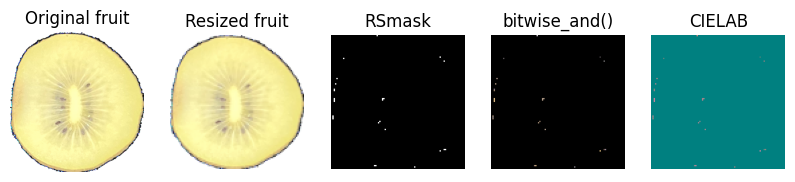

Rosso B2 (6-10) 1,1,0_FRUIT_ID_5_i_1.png


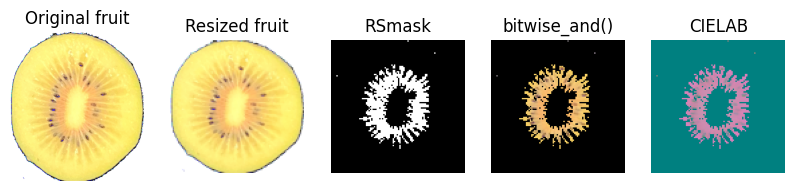

Pre-harvest a (1-6)_FRUIT_ID_4_i_2.png


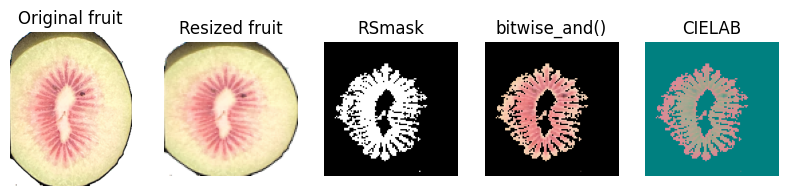

Pre-harvest a (1-6)_FRUIT_ID_1_i_3.png


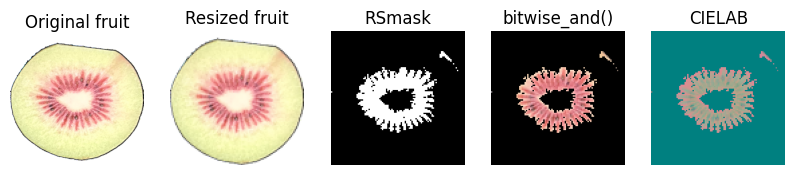

T0 5 (33-40)_FRUIT_ID_3_i_4.png


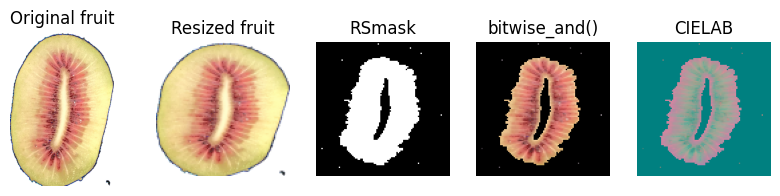

T0 Gul 1.3 (17-24)_FRUIT_ID_3_i_5.png


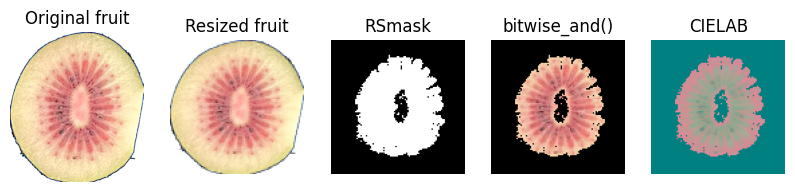

In [66]:
HOME = os.path.join(os.getcwd(), 'image_database/i1_db')

for path, subdirs, files in os.walk(HOME):
    for file in files[0:1]:
        if file.endswith('.png'):
            print(file)
            # open the image file
            im_raw = cv2.imread(path + '\\' + file)
            im = cv2.resize(im_raw, (100,100), interpolation= cv2.INTER_AREA)
            # colorspace conversion
            hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
            # get red shades mask
            rs_mask = image_segmenter(im)

            # colorspace conversion
            rgb_out = cv2.bitwise_and(im[:,:,::-1], im[:,:,::-1], mask=rs_mask)
            cielab_out = cv2.cvtColor(rgb_out, cv2.COLOR_RGB2LAB)
            
            fig, ax = plt.subplots(1,5, figsize=(10,2))
            ax[0].set_title('Original fruit')
            ax[0].imshow(cv2.cvtColor(im_raw, cv2.COLOR_BGR2RGB))
            ax[0].axis('off')
            
            ax[1].set_title('Resized fruit')
            ax[1].imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
            ax[1].axis('off')

            ax[2].set_title('RSmask')
            ax[2].imshow(rs_mask, cmap='gray')  
            ax[2].axis('off')

            ax[3].set_title('bitwise_and()')
            ax[3].imshow(rgb_out) 
            ax[3].axis('off')
            
            ax[4].set_title('CIELAB')
            ax[4].imshow(cielab_out) 
            ax[4].axis('off')
        
            plt.show()

### Data extraction

To get coordinates of perceived color intensities, the CIE L\*A\*B\* colorspace is used. It is described as a "device-independent" color space that covers the entire range of human color perception.
>  It is based on the opponent color model of human vision, where red and green form an opponent pair and blue and yellow form an opponent pair.
> * The lightness value, L*, also referred to as "Lstar," defines black at 0 and white at 100. 
> * The a* axis is relative to the green–magenta opponent colors, with negative values toward green and positive values toward magenta. 
> * The b* axis represents the blue–yellow opponents, with negative numbers toward blue and positive toward yellow.

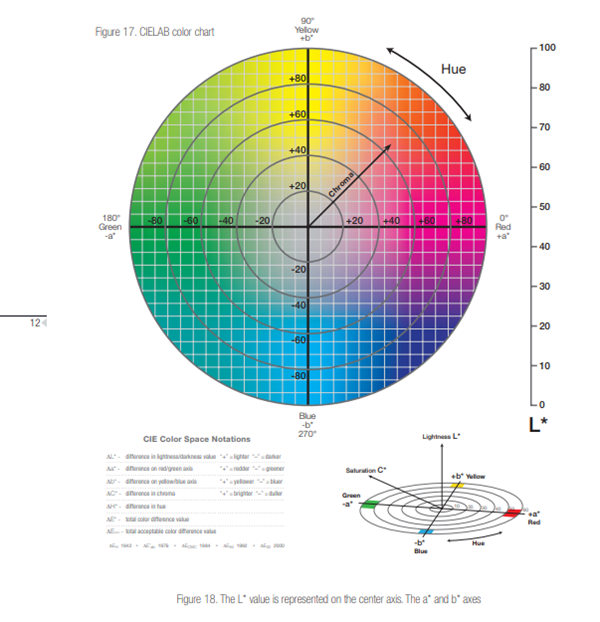

In [28]:
def get_intensity_descriptors(cv2_im_mtx):
    '''Extractor of descriptors for color intensity from fruit images (cv2_im_mtx)'''
    cv2_im_mtx = cv2_im_mtx.astype('uint8')
    
    # changing colorspace
    lab_im = cv2.cvtColor(cv2_im_mtx, cv2.COLOR_BGR2LAB) # 0-179 since it is int-8 array
    
    # split channels
    l, a, b = cv2.split(lab_im) 
    
    # get descriptors
    # source: https://docs.opencv.org/4.3.0/de/d25/imgproc_color_conversions.html#color_convert_rgb_lab
    l_avg = np.mean(l[l !=128]*100/255)  # 128 is black
    l_dev = np.std(l[l !=128]*100/255)  # 0 is black
    a_avg = np.mean(a[a !=128]-128)  # 128 is black
    a_dev = np.std(a[a !=128]-128)  # 128 is black
    b_avg = np.mean(b[b !=128]-128)  # 128 is black
    b_dev = np.std(b[b !=128]-128)  # 128 is black
    
    descriptors = [l_avg, l_dev, a_avg, a_dev, b_avg, b_dev]
    
    return descriptors

In [29]:
# unbalanced red quantity dataset
HOME = os.path.join(os.getcwd(), 'image_database/i1_db')

# dir of the balanced dataset 
PATH = os.path.join(os.getcwd(), 'image_database/red_quality_db_ISHS')
os.makedirs(PATH, exist_ok=True)

# regenerate dataset or not
REGENERATE = False


intensity_predictors = []

idx = 0
for path, subdirs, files in os.walk(HOME):
    for file in files[10:]:
        if file.endswith('.png'):
            # open the image file
            im = cv2.imread(path + '\\' + file)
            # save image in red_quantity_db
            if REGENERATE == True:
                cv2.imwrite(f'{PATH}/{file}', im)
                print(f'image saved at: {PATH}/{file}')
            
            
            # make image standardized in size to take into account the fruit size variations
            im = cv2.resize(im, (100, 100), interpolation= cv2.INTER_AREA)
            
            ## --- ( q - red quantity ) ##
            # get fruit and background pixels count
            bkg_mtx = bkg(im)  # function to segment the background 
            f_mask = 1 - bkg_mtx
            fruit_pixels = np.sum(f_mask)
            
            # segmentation of red shades
            rs_mask = image_segmenter(im)

            ## get descriptors
            ## ----( rq - red quality ) ##
            r_masked = cv2.bitwise_and(im, im, mask=rs_mask)
            intensity_descriptors = get_intensity_descriptors(r_masked)
            # list descriptors
            intensity_predictors.append(intensity_descriptors)

In [30]:
# three locators
L_means = [point[0] for point in intensity_predictors]  
L_devs = [point[1] for point in intensity_predictors]  
a_means = [point[2] for point in intensity_predictors]  
a_devs = [point[3] for point in intensity_predictors]
b_means = [point[4] for point in intensity_predictors]  
b_devs = [point[5] for point in intensity_predictors]

# zip predictors
intensity_predictors = list(zip(L_means, L_devs, a_means, a_devs, b_means, b_devs))  # over-write memory space

In [31]:
f'sample intensity descriptor: {intensity_predictors[:1]}'

'sample intensity descriptor: [(0.002315294117647059, 0.04095834435331281, 5.425, 1.9734170871865886, 60.0, 90.73743467435065)]'

### *i_clf*

#### Design and train

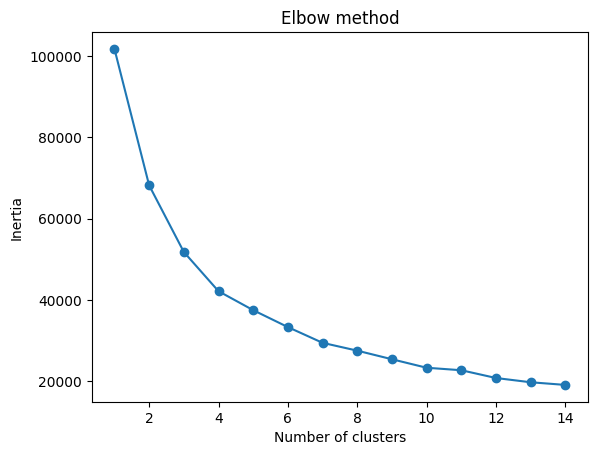

In [209]:
inertias = []
for i in range(1,15):
    kmeans = KMeans(n_clusters=i, n_init='auto')
    kmeans.fit(intensity_predictors)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,15), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=6) # set cluster no.
kmeans.fit(intensity_predictors)  # train

## uncomment to save a new model
# models_dir = os.path.join(os.getcwd(), 'models')
# os.makedirs(models_dir, exist_ok=True)
# joblib.dump(kmeans,  os.path.join(models_dir, 'i_clf.pkl'))

#### Predictions

In [32]:
# load the model
i_clf = joblib.load(os.path.join(os.getcwd(), 'models\i_clf.pkl') , mmap_mode ='r') # load the model

# make predictions
pred_intensity = i_clf.predict(intensity_predictors)

Clustering evaluation using the *Silhouette score*.

> The `silhouette score` ranges from -1 to 1, where:
> + A **high value, close to 1**, indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. This suggests that the clustering is appropriate.
> + **A value near 0** indicates that the object is on or very close to the decision boundary between two neighboring clusters. This suggests ambiguity in the assignment.
> + **A negative value** indicates that the object is likely assigned to the wrong cluster.

In [33]:
silohuette_score = silhouette_score(intensity_predictors, pred_intensity)
print(f'Silhouette: {silohuette_score}')

Silhouette: 0.21110043442949844


In [34]:
print(f'sample descriptor (lm, ld, am, ad, bm, bd): {intensity_predictors[0]}')
print(f'sample prediction (i_cluster): {pred_intensity[0]}')

# lists of descriptors: i(x1, x2, x3, x4, x5, x6)
lm = []
ld = []
am = []
ad = []
bm = []
bd = []

clust_i_quality = []

for i in intensity_predictors:
    lm.append(i[0])
    ld.append(i[1])
    am.append(i[2])
    ad.append(i[3])
    bm.append(i[4])
    bd.append(i[5])
    
    # append the predicted cluster for each indexed predictor element
    clust_i_quality.append(pred_intensity[intensity_predictors.index(i)])

sample descriptor (lm, ld, am, ad, bm, bd): (0.002315294117647059, 0.04095834435331281, 5.425, 1.9734170871865886, 60.0, 90.73743467435065)
sample prediction (i_cluster): 1


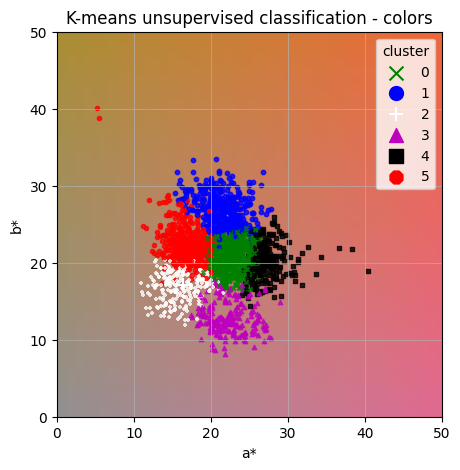

In [35]:
# Visualize the CIELAB color space with samples
# Define the range of values for each axis of the a*b plane
a_range = np.linspace(-128, 127, 256)
b_range = np.linspace(-128, 127, 256)

# Create a 2D meshgrid
a, b = np.meshgrid(a_range, b_range)

# Define a constant value for the L axis
L = np.ones_like(a) * 60

# Convert the L, a, and b values to RGB
rgb = color.lab2rgb(np.dstack((L, a, b)))

# plotting
fig, ax = plt.subplots(figsize=(5,5))
# Plot the RGB values
ax.imshow(rgb, origin='lower', extent=(-128, 127, -128, 127))
plt.grid('--', lw=.5)

# Get the centroids
centroids = i_clf.cluster_centers_
i_cluster_lab = i_clf.labels_

cluster_labs = list(np.unique(i_cluster_lab))

i_clust_centers = []
for ind, centroid in enumerate(centroids): 
    label = cluster_labs[ind]
    i_clust_centers.append((centroid[2], centroid[4], label))

# assign predefined colors and markers to each cluster
colors = ['g','b','w','m','k','r','c']
m = ['x','o', '+', '^', 's', '8']

for i in range(0,len(am)):
    plt.scatter(am[i], bm[i], c=colors[pred_intensity[i]], marker=m[pred_intensity[i]], s=10, alpha=.8)

for i in range(0, len(i_clust_centers)):
        plt.scatter(i_clust_centers[i][0], i_clust_centers[i][1], c=colors[i_clust_centers[i][2]], marker=m[i], s=100, label=i_clust_centers[i][2])
         
        
plt.title('K-means unsupervised classification - colors')
plt.ylabel('b*')
plt.xlabel('a*')
plt.legend(title='cluster', loc='upper right')

plt.ylim([0,50])
plt.xlim([0,50])


# save the plot
images_dir = os.path.join(os.getcwd(), 'images')
plt.savefig(os.path.join(images_dir, 'i_clf_classes.png'), dpi=400)
plt.show()

Sorting cluster centers for increasing "red intensity"

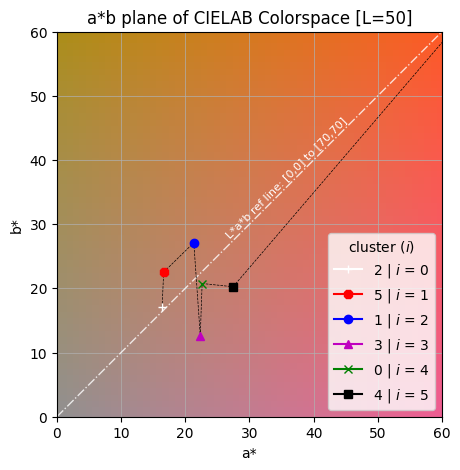

remapping_quality_clusters= {2: 0, 5: 1, 1: 2, 3: 3, 0: 4, 4: 5}


In [38]:
# number of sorting classes
MAX_CLASS_i = 5  # 0, 1, 2, 3, 4, 5

centers = []
for ind, centroid in enumerate(centroids): 
    label = cluster_labs[ind]
    centers.append((centroid[2], centroid[4], label))

# visualization of CIELAB color space
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(rgb, origin='lower', extent=(-128, 127, -128, 127))
plt.grid('--', lw=.5)

i_clust_centers = []
for ind, centroid in enumerate(centroids): 
    label = cluster_labs[ind]
    i_clust_centers.append((centroid[2], centroid[4], label))

# assign predefined colors and markers to each cluster
colors = ['g','b','w','m','k','r','c']
m = ['x','o', '+', '^', 's', '8']

# centroids are sorted according to increasing a and b coordinate
sorted_list = sorted(i_clust_centers, key=lambda x: (x[0], x[1]))

# plot reference line from Lab 50,0,0 to 50, 70,70 (pure red)
ax.plot([0,70], [0,70], '-.', c='white', lw=1, alpha=.8)
ax.text(26, 28, 'L*a*b ref line: [0,0] to [70,70]', c= 'white', fontsize=8, rotation= 45)

# use a dictionary to remap clusters in real world labels
remapping_quality_clusters = dict()
order = 0
for clust in sorted_list:
    x, y, lab = clust
    
    if sorted_list.index(clust)+1 <= MAX_CLASS_i:
        x2, y2, lab2 = sorted_list[sorted_list.index(clust)+1]
    else:
        x2, y2 = 70, 70
        
    plt.plot([x, x2], [y, y2], linestyle='--', linewidth=.5, color='k')
    plt.plot(x, y, c=colors[clust[2]], marker=m[clust[2]], label= '{} | $i$ = {}'.format(lab, order))
    
    remapping_quality_clusters[lab] = order
    order +=1


plt.title('a*b plane of CIELAB Colorspace [L=50]')
plt.ylabel('b*')
plt.xlabel('a*')
plt.legend(title='cluster ($i$)', loc='lower right')

plt.ylim([0,60])
plt.xlim([0,60])

# save plot
images_dir = os.path.join(os.getcwd(), 'images')
plt.savefig(os.path.join(images_dir, 'i_clf_CIELAB_zoom_movement_vectors.png'), dpi=400)
plt.show()

print(f'{remapping_quality_clusters= }')

clust_colors= [array([0.60684326, 0.42347485, 0.3560378 ]), array([0.6164674 , 0.42170655, 0.31961015]), array([0.64797685, 0.40783167, 0.28956239]), array([0.63297371, 0.40793803, 0.38641209]), array([0.64683921, 0.40528371, 0.33280552]), array([0.67210132, 0.39070666, 0.33719934])]


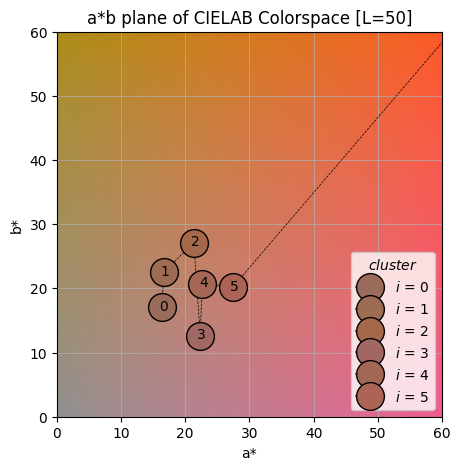

In [49]:
# number of sorting classes
MAX_CLASS_i = 5  # 0, 1, 2, 3, 4, 5

# pack cluster coordinates and labels
i_clust_centers = []
for ind, centroid in enumerate(centroids): 
    clust_label = cluster_labs[ind]
    i_clust_centers.append((centroid[2], centroid[4], clust_label))  # a*, b*, class

# visualizing
fig, ax = plt.subplots(figsize=(5,5))
plt.grid('--', lw=.5)
ax.imshow(rgb, origin='lower', extent=(-128, 127, -128, 127))

# assign predefined markers to each cluster
m = ['x','o', '+', '^', 's', '8']

# centroids are sorted according to increasing a and b coordinate
sorted_list = sorted(i_clust_centers, key=lambda x: (x[0], x[1]))

# converting colors from CIE L*A*B to RGB
L_STAR = 50
# rgb colors corresponding to cielab coordinates at L*=50
clust_colors = [color.lab2rgb((L_STAR, i[0], i[1])) for i in sorted_list]   # relative RGB values D: [0, 1]
print(f'{clust_colors= }')


i_pred_list = []  # sorted i scores
# connect sorted clusters towards a*= 70, b*= 70
for i_pred, coord in enumerate(sorted_list):
    x, y, lab = coord
    if sorted_list.index(coord)+1 <= MAX_CLASS_i:
        x2, y2, lab2 = sorted_list[sorted_list.index(coord)+1]
    else:
        x2, y2 = 70, 70
    
    # add connector line
    plt.plot([x, x2], [y, y2], linestyle='--', linewidth=.5, color='k')
    # add points with their RGB color
    plt.plot(x, y, c=clust_colors[i_pred], marker='o', markersize=20, markeredgecolor='k',  label= '$i$ = {}'.format(i_pred))
    plt.text(x-.5, y-.5, '{}'.format(i_pred))
    i_pred_list.append((i_pred, clust_colors[i_pred])) # i, color

plt.title('a*b plane of CIELAB Colorspace [L=50]')
plt.ylabel('b*')
plt.xlabel('a*')
plt.legend(title='$cluster$', loc='lower right')
# manage axis
plt.ylim([0,60])
plt.xlim([0,60])

# save plot
images_dir = os.path.join(os.getcwd(), 'images')
plt.savefig(os.path.join(images_dir, 'i_clf_classes.png'), dpi=400)
plt.show()

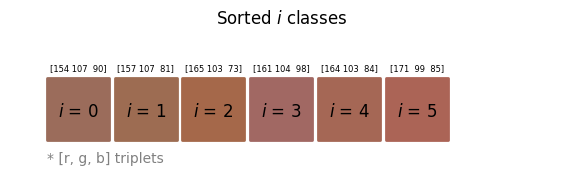

In [50]:
fig, ax = plt.subplots(figsize=(7,2))

for i, color_coord in enumerate(clust_colors):
    ax.scatter(i, 0, s=2000, c=[color_coord], marker='s', linewidths=2, label=i_pred_list[i])

ax.set_xlim(-1, len(colors))
ax.set_ylim(-1, 1)
ax.axis('off')

for i, color_coord in enumerate(clust_colors):
    ax.text(i, .5, str((color_coord*255).astype('int')), ha='center', fontsize=6, rotation=0)
    ax.text(i, -.1, f'$i$ = {i}', ha='center', fontsize=12)

plt.text(0.4, -.7, '* [r, g, b] triplets', ha='center', c='gray', fontsize=10, rotation=0)

plt.title('Sorted $i$ classes')

# save plot
images_dir = os.path.join(os.getcwd(), 'images')
plt.savefig(os.path.join(images_dir, 'i_clf_classes_colors.png'), dpi=400)
plt.show()

# Fruit Sorting: $f_{score} = f(q, i)$

### Core functions

In [7]:
class KiwiFeatures():
    # TODO: KiwiSorter()
    def __init__(self):
        self.self = self
        # kmean cluster - sorted cluster
        self.remapped_quantity_clusters= {0: 0, 4: 1, 2: 2, 5: 3, 1: 4, 3: 5}          
        self.remapping_quality_clusters= {2: 0, 5: 1, 1: 2, 3: 3, 0: 4, 4: 5}
    
    def image_segmenter(self, cv2_im_mtx ):
        ''' Applies red shades recognition to fruit images (cv2_im_mtx)'''
        L_CV = 14  # lower computer vision bound
        U_CV = 164  # upper computer vision bound
        L_SB = 22  # lower sorting bound
        U_SB = 147  # upper sorting bound

        # ensure the required data type 
        cv2_im_mtx = cv2_im_mtx.astype('uint8')
        
        # changing colorspace
        hue = cv2.cvtColor(cv2_im_mtx, cv2.COLOR_BGR2HSV) # 0-179 since it is int8 array
        
        # get hue color angle
        h, s, v = cv2.split(hue)
        
        # computer vision boundaries
        red_hue_cv = np.where( (((h >= 0) & (h <= L_CV))|(h >= U_CV)) 
                        & (s > 50) 
                        & ((v > 50) & (v < 253)),
                        1,
                        0)
        
        # sorting boundaries
        sat_condition = np.where(
            ((h <= L_SB) & (h > L_CV)),
            50 + (h - L_CV).astype('int') * int(100/ (L_SB - L_CV )),
            150 - (h - U_CV).astype('int') * int(100/ (U_CV - U_SB ))
        )

        red_hue_sb_lower = np.where(
            ((h > L_CV) & (h <= L_SB)) &
            (s > sat_condition) & ((v > 50)&(v < 253)),  #  100 perchè tra hue 20 e 40 abbiamo il marrone
            1,
            0
        )
        
        red_hue_sb_upper = np.where(
            ((h >= U_SB) & (h <= U_CV)) &
            (s > sat_condition) & ((v > 50) & (v < 253)),
            1,
            0
        )
    
        red_mtx = red_hue_sb_lower + red_hue_sb_upper + red_hue_cv  
        return red_mtx.astype('uint8')
    
    def bkg(self, im_mtx_bgr):
        ''' removes white background from fruit images (cv2_im_mtx)'''
        # TODO: does it make sense to give directly Fmask?
        im_gray = cv2.cvtColor(im_mtx_bgr, cv2.COLOR_BGR2GRAY)
        return np.where(im_gray == 255, 1, 0).astype('int8')
        

    def get_intensity_descriptors(self, cv2_im_mtx):
        '''Extractor of descriptors for color intensity from fruit images (cv2_im_mtx)'''
        cv2_im_mtx = cv2_im_mtx.astype('uint8')
        
        # changing colorspace
        lab_im = cv2.cvtColor(cv2_im_mtx, cv2.COLOR_BGR2LAB) # 0-179 since it is int-8 array
        
        # split channels
        l, a, b = cv2.split(lab_im) 
        
        # get descriptors
        # source: https://docs.opencv.org/4.3.0/de/d25/imgproc_color_conversions.html#color_convert_rgb_lab
        l_avg = np.mean(l[l !=128]*100/255)  # 128 is black
        l_dev = np.std(l[l !=128]*100/255)  # 0 is black
        a_avg = np.mean(a[a !=128]-128)  # 128 is black
        a_dev = np.std(a[a !=128]-128)  # 128 is black
        b_avg = np.mean(b[b !=128]-128)  # 128 is black
        b_dev = np.std(b[b !=128]-128)  # 128 is black
        
        descriptors = [l_avg, l_dev, a_avg, a_dev, b_avg, b_dev]
        
        return descriptors

### Visualizing the difference between $r$ and $k$

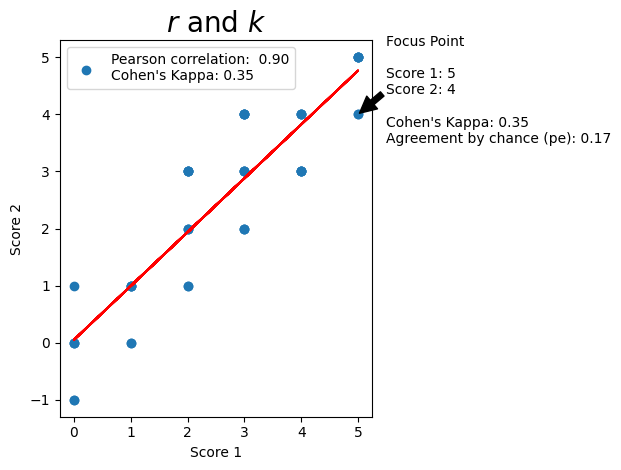

Cohen's Kappa: 0.35
Observed Agreement (p0): 0.46
Expected Agreement (pe): 0.17


In [5]:
# Generate sample categorical data in the range 0 to 5
np.random.seed(42)
cat_data1 = np.random.randint(0, 6, 50)
cat_data2 = cat_data1 + np.random.randint(-1, 2, 50)  # Introduce some variation

# Calculate Pearson correlation
pearson_corr, _ = pearsonr(cat_data1, cat_data2)

# Calculate Cohen's Kappa
kappa = cohen_kappa_score(cat_data1, cat_data2)

# Calculate p0 (observed agreement)
p0 = np.sum(cat_data1 == cat_data2) / len(cat_data1)

# agreement by chance (pe)
conf_matrix = confusion_matrix(cat_data1, cat_data2)

# Calculate the marginal probabilities
marginal_prob1 = np.sum(conf_matrix, axis=1) / np.sum(conf_matrix)
marginal_prob2 = np.sum(conf_matrix, axis=0) / np.sum(conf_matrix)
pe = np.sum(marginal_prob1 * marginal_prob2)


# Fit a linear regression line
regression_line = np.polyfit(cat_data1, cat_data2, 1)
line_function = np.poly1d(regression_line)

# Plot the data
plt.scatter(cat_data1, cat_data2, label=f'Pearson correlation: {pearson_corr: .2f}\nCohen\'s Kappa: {kappa:.2f}', marker='o')
plt.plot(cat_data1, line_function(cat_data1), color='red')

plt.xlabel('Score 1')
plt.ylabel('Score 2')

# Annotate a specific point
focus_index = 36  # Choose the index of the point to focus on
plt.annotate(f'Focus Point\n\nScore 1: {cat_data1[focus_index]}\nScore 2: {cat_data2[focus_index]}\n\nCohen\'s Kappa: {kappa:.2f}\nAgreement by chance (pe): {pe:.2f}',
             xy=(cat_data1[focus_index], cat_data2[focus_index]),
             xytext=(cat_data1[focus_index] + 0.5, cat_data2[focus_index] - 0.5),
             arrowprops=dict(facecolor='black', shrink=0.05),
             )

plt.legend()
plt.title('$r$ and $k$', fontsize=20)
plt.tight_layout()  # Apply tight layout

# save the plot
images_dir = os.path.join(os.getcwd(), 'images')
plt.savefig(os.path.join(images_dir, 'Pearson_vs_Cohens_visualization.png'), dpi=400)
plt.show()

# Print the values
print(f"Cohen's Kappa: {kappa:.2f}")
print(f"Observed Agreement (p0): {p0:.2f}")
print(f"Expected Agreement (pe): {pe:.2f}")


### Comparative Index

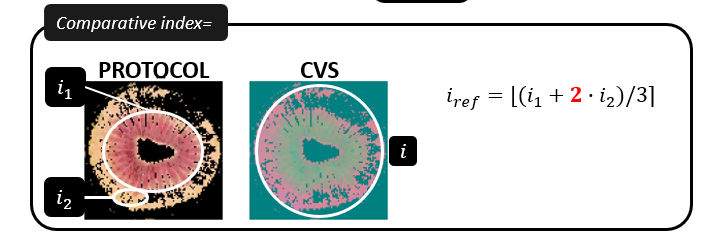

A comparative index is needed to solve the difference in dimensionality between human rated scores and the ones from the CVS.

The index is based on the following statement:
> *Having red in the outer-pericarp ($i_2$) is rewarding for a fruit because it appears redder to the observer's eye. For this reason, in the comparative index of In $i_1$ and $i_2$, the value of $i_2$ is duplicated. Additionally, the inner-pericarp ($i_1$) develops color earlier from a physiological perspective. Fruits with a higher $i_2$ value should, therefore, be considered better.*

The comparative index is given by the formula $i_1 + 2*i_2$.

This index has a maximum value of 15 (= 5 + 2x5), which needs to be rescaed to 0-5. Therefore, it is divided by 3.

The comparative index becomes rounded $(i_1 + 2*i_2)/3$.

In [102]:
# protocol scores
fruit_1 = np.array([0, 0, 0])  # q, i1, i2
fruit_2 = np.array([0, 3, 4])
fruit_3 = np.array([0, 5, 5])

In [107]:
print(f'fruit 1 intensity index is: {np.round((fruit_1[1] + fruit_1[2]*2)/3, 0)}')
print(f'fruit 2 intensity index is: {np.round((fruit_2[1] + fruit_2[2]*2)/3, 0)}')
print(f'fruit 3 intensity index is: {np.round((fruit_3[1] + fruit_3[2]*2)/3, 0)}')

fruit 1 intensity index is: 0.0
fruit 2 intensity index is: 4.0
fruit 3 intensity index is: 5.0


### Data generation

In [8]:
# unbalanced red quantity dataset
HOME = os.path.join(os.getcwd(), 'image_database/test_db')

kmean_red_quantity_clf = joblib.load(os.path.join(os.getcwd(), 'models\q_clf.pkl') , mmap_mode ='r')
kmean_red_quality_clf = joblib.load(os.path.join(os.getcwd(), 'models\i_clf.pkl') , mmap_mode ='r') 

red_quantity = []
red_quality = []
file_list = []
segmented_images_list = []
images_list = []
title_lists = []

red_quantity_predictors = []
red_quality_predictors = []

idx = 0
kf = KiwiFeatures()
for path, subdirs, files in os.walk(HOME):
    for file in files:
        if file.endswith('.png'):
            # open the image file
            im = cv2.imread(path + '\\' + file)
            
            # make image standardized in size to take into account the fruit size variations
            im = cv2.resize(im, (100, 100), interpolation= cv2.INTER_CUBIC)
            
            ## --- ( q - red quantity ) ##
            bkg_mtx = kf.bkg(im)  # function to segment the background 
            f_mask = 1 - bkg_mtx
            fruit_pixels = np.sum(f_mask)
            
            # segmentation of red shades
            rs_mask = kf.image_segmenter(im)
            
            ## get descriptors
            frp = (np.sum(rs_mask)/fruit_pixels)  # red percentage over fruit pixels
            mv = np.mean(rs_mask)  # mean value
            
             # prediction
            pred = kmean_red_quantity_clf.predict([[frp,   mv]])
            # ranking clusters

            # save descriptors
            q = kf.remapped_quantity_clusters[int(pred)]
            red_quantity.append(q)
            red_quantity_predictors.append((frp, mv))
             
            ## ----( i - red quality ) ##
            r_masked = cv2.bitwise_and(im, im, mask=rs_mask)
            descriptors = kf.get_intensity_descriptors(r_masked)

            if q != 0:      
                prediction_quality = kmean_red_quality_clf.predict([descriptors])
                i = kf.remapping_quality_clusters[prediction_quality[0]]
                red_quality.append(i) 
            else:
                # if there is no red in the fruit,
                # it has not red quality
                red_quality.append(0)
            
            red_quality_predictors.append(descriptors)
            
            # get label
            file_list.append(file)
            images_list.append(im[:,:,::-1])  # RGB
            segmented_images_list.append(r_masked[:,:,::-1]) # RGB

Merge estimated and ground truth data within a dataframe

In [11]:
# init the dataset
df = pd.DataFrame(columns=['image', 'fruit', 'frp', 'mv','lm','ld', 'am','ad', 'bm', 'bd', 'chroma' ,'q_ref', 'i1_ref', 'i2_ref', 'i_index_ref'])

# il valore di qualità deve essere confrontato con la media di I e O (?)


# inti list
mv = []  # q
frp = []
lm = []  # i
ld = []
am = []
ad = []
bm = []
bd = []
c = []

# CREARE LISTE DEI PREDICTORS QUANTITà E QUALITà
for obj in red_quantity_predictors:  # data = list(zip(frp, mv))
    # add data to list
    frp.append(obj[0])
    mv.append(obj[1])
    
    
for obj in red_quality_predictors:  # data = list(zip(lm, ld, am, ad, bm, bd))
    # add data to list
    lm.append(obj[0])
    ld.append(obj[1])
    am.append(obj[2])
    ad.append(obj[3])
    bm.append(obj[4])
    bd.append(obj[5])
    c.append(np.sqrt(obj[2]**2 + obj[4]**2))

# add predictors to the dataset
# quantity
df['frp'] = frp
df['mv'] = mv
# quality
df['lm'] = lm
df['ld'] = ld
df['am'] = am
df['ad'] = ad
df['bm'] = bm
df['bd'] = bd
df['chroma'] = c

list_images = []
list_fruit_id = []

# process the same images to get refrence data
for path, subdirs, files in os.walk(HOME):
    # loop over traning fruits
    for file in files:
        if file.endswith('.png'):
            t = '_FRUIT_ID_'
            # get original image name
            image = file[0:file.find(t)]
            # get fruit id
            id_fruit = file[file.find(t) + len(t) : file.find(t) + len(t) + 2]
            # append data to lists
            list_images.append(image)
            list_fruit_id.append(id_fruit)

# add info to the dataset
df['image'] = list_images
df['fruit'] = list_fruit_id
# transform str column into int
df['fruit'] = df["fruit"].str.replace("_","").astype('uint8')

# loop over the dataset to create the image complete filename (with file format)
for idx, row in df.iterrows():
    df.iloc[idx,0] = row['image'] + '.JPG'

# import another dataset with complete fruit evaluations
dfs_dir = os.path.join(os.getcwd(), 'data')
os.makedirs(dfs_dir, exist_ok=True)
df1 = pd.read_csv(os.path.join(dfs_dir, 'initial_rater_dataset.csv'), sep=';')  # open dataset with full evaluations

# list to host Red quantity data
r_quantity = []
r_quality = []
# separated params
rq_1 = []
rq_2 = []
rq_index = []

for idx, row in df.iterrows():
    df.iloc[idx,0] = row['image']
    # complete data with evaluations copied
    df_eval = df1.copy()
    # dataset filtering to get data about fruit id in a specific image
    df_eval = df_eval.loc[(df_eval['image'] == row.image) & (df_eval['FRUIT_ID'] == row.fruit)]
#     print(df_eval)
    
    # append red quantity REFERENCE info to its list
    r_quantity.append(df_eval['q'].values)
    
    # reference quality
    rq1 = df_eval['i1'].values
    rq2 = df_eval['i2'].values
    rq_ind = np.round((rq1 + 2*rq2)/3, 0)  # COMPUTE THE COMPARATIVE INDEX
    rq_1.append(rq1)
    rq_2.append(rq2)
    rq_index.append(rq_ind)

    
# process red quantity data
s = [q for q in r_quantity]

# red quantity score
rq = []
for score in s:
    rq.append(str(score))
# process list of arrays into a list of values
red_q_scores =  [i[1] for i in rq]

rq = []
s = [rq for rq in rq_1]
for score in s:
    rq.append(str(score))
# process 
rq_1 =  [int(i[1]) for i in rq]

rq = []
s = [rq for rq in rq_2]
for score in s:
    rq.append(str(score))
# process 
rq_2 =  [int(i[1]) for i in rq]


rq = []
s = [rq for rq in rq_index]
for score in s:
    rq.append(str(score))
# process 
rq_index =  [int(i[1]) for i in rq]


# add the dataset with an additional column named Red_Q_ref
df['q_ref'] = red_q_scores
df['i1_ref'] = rq_1
df['i2_ref'] = rq_2
df['i_index_ref'] = rq_index

# remove characters
df = df.loc[(df.q_ref != '[')]
df = df.loc[(df.q_ref != ']')]


# create a columns to host predicted scores
df['q_pred'] = 0
df['i_pred'] = 0

# score predictions based on preditor1 and preditor2
for idx, row in df.iterrows():
    frp = float(row['frp'])
    mv = float(row['mv'])
    
    lm = float(row['lm'])
    ld = float(row['ld'])
    am = float(row['am'])
    ad = float(row['ad'])
    bm = float(row['bm'])
    bd = float(row['bd'])
    # prediction
    pred_q = kmean_red_quantity_clf.predict([[frp, mv]])
    pred_rq = kmean_red_quality_clf.predict([[lm, ld, am, ad, bm, bd]])
    
    # ranking clusters
    q = kf.remapped_quantity_clusters[int(pred_q)]
    if q != 0:
        rq = int(kf.remapping_quality_clusters[pred_rq[0]])
    else:
        rq = 0

    # add predicrtions into the target column
    df.loc[idx, 'q_pred'] = q
    df.loc[idx, 'i_pred'] = rq


df['q_pred'] = df['q_pred'].astype('int')
df['i_pred'] = df['i_pred'].astype('int')

# # save the df
df.to_csv(os.path.join(dfs_dir, '2023_09_15_Piani_et_al_2023_ISHS_evaluated_fruits_with_CVS_RED_QUALITY_DATA.txt'), index=False)

### Pearson correlation ($r$)

 The test has to define if predictors have Pearson correlation with target variable, but also if predictions and reference data are related each other.

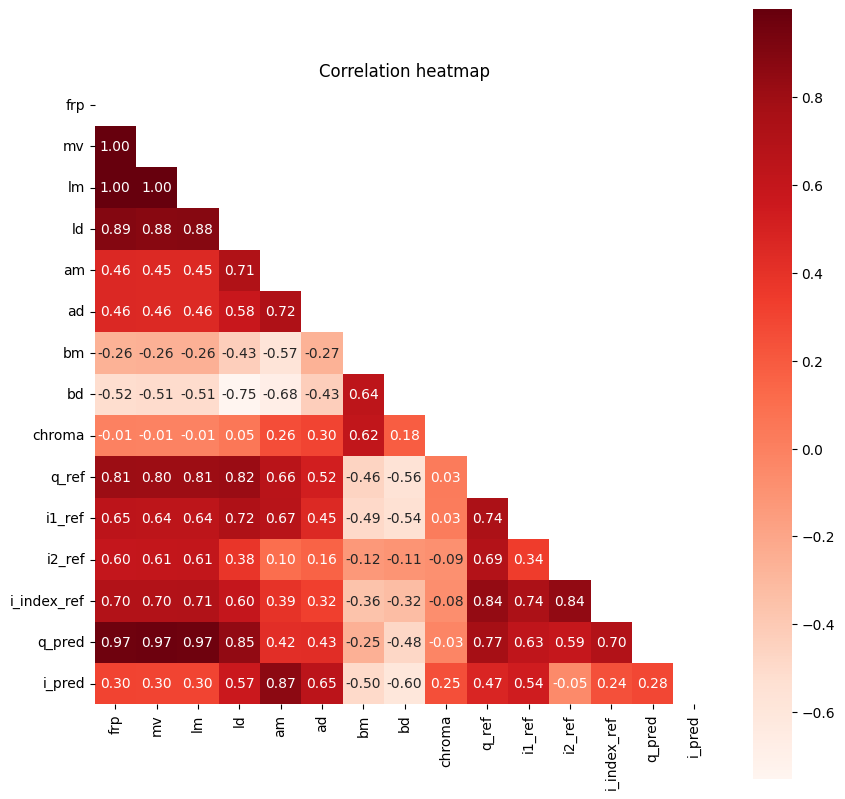

In [12]:
# import the dataset with complete fruit evaluations
dfs_dir = os.path.join(os.getcwd(), 'data')

# remove categorical data
df = pd.read_csv(os.path.join(dfs_dir, '2023_09_15_Piani_et_al_2023_ISHS_evaluated_fruits_with_CVS_RED_QUALITY_DATA.txt'))
df = df.drop(['fruit', 'image'], axis=1)

fig, ax = plt.subplots(1,1, figsize=(10, 10))
# Mask the lower triangle of the correlation matrix
mask = np.triu(np.ones_like(df.corr(), dtype=bool))

# Plot the heatmap
sns.heatmap(df.corr(), cmap="Reds", annot=True, fmt=".2f", mask=mask)  # mask half of the matrix
# sns.heatmap(df.corr(), cmap="Reds", annot=True, fmt=".2f")  # whole matrix

plt.title('Correlation heatmap')

# save the plot
plt.gca().set_aspect('equal')

images_dir = os.path.join(os.getcwd(), 'images')
plt.savefig(os.path.join(images_dir, 'heatmap_corr_red_quantity_quality_Piani_et_al_2023_ISHS.png'), dpi=400)
plt.show()

### Cohen's kappa score ($k$)
[medium post on cohens kappa score ($k$)](https://towardsdatascience.com/comprehensive-guide-on-multiclass-classification-metrics-af94cfb83fbd)

> *Cohen’s kappa coefficient (κ) is a statistic that is used to measure inter-rater reliability (and also intra-rater reliability) for qualitative (categorical) items. It is generally thought to be a more robust measure than simple percent agreement calculation, as κ takes into account the possibility of the agreement occurring by chance*

In [16]:
# IMPORT THE DATASET
dfs_dir = os.path.join(os.getcwd(), 'data')

# remove categorical data
df = pd.read_csv(os.path.join(dfs_dir, '2023_09_15_Piani_et_al_2023_ISHS_evaluated_fruits_with_CVS_RED_QUALITY_DATA.txt'))
df.head(10)

,image,fruit,frp,mv,lm,ld,am,ad,bm,bd,chroma,q_ref,i1_ref,i2_ref,i_index_ref,q_pred,i_pred
0,"Giallo A1 (1-5) 0,0,0.JPG",1,0.004014,0.0032,0.001434,0.028781,7.843750,9.107378,40.906250,65.461038,41.651479,0,0,0,0,0,0
1,"Giallo A1 (1-5) 0,0,0.JPG",2,0.010443,0.0084,0.004199,0.052757,5.964286,1.775806,34.108434,42.399140,34.625972,0,0,0,0,0,0
2,"Giallo A1 (1-5) 0,0,0.JPG",3,0.002933,0.0023,0.000966,0.023683,6.130435,3.517711,49.869565,79.233449,50.244958,0,0,0,0,0,0
3,"Giallo A1 (1-5) 0,0,0.JPG",4,0.006982,0.0055,0.002573,0.039794,6.454545,9.672488,28.018182,27.416313,28.752038,0,0,0,0,0,0
4,"Giallo A1 (1-5) 0,0,0.JPG",5,0.004097,0.0033,0.001773,0.034647,7.937500,5.878656,30.090909,57.200002,31.120198,0,0,0,0,0,0
5,"Giallo A2 (6-10) 0,0,0.JPG",1,0.004636,0.0038,0.002069,0.037799,8.368421,11.395800,21.631579,34.552341,23.193872,0,0,0,0,0,0
6,"Giallo A2 (6-10) 0,0,0.JPG",2,0.009003,0.0072,0.003263,0.045525,5.694444,5.029466,33.902778,8.177136,34.377682,0,0,0,0,0,0
7,"Giallo A2 (6-10) 0,0,0.JPG",3,0.006331,0.0052,0.002524,0.040017,6.076923,2.137991,23.269231,32.485568,24.049659,0,0,0,0,0,0
8,"Giallo A2 (6-10) 0,0,0.JPG",4,0.004570,0.0037,0.001548,0.030563,8.135135,6.670476,26.702703,53.095460,27.914418,0,0,0,0,0,0
9,"Giallo A2 (6-10) 0,0,0.JPG",5,0.015680,0.0133,0.006752,0.067154,6.308271,1.888551,15.624060,5.631012,16.849497,0,0,0,0,0,0


#### Quantity

In [79]:
# Assuming 'q_ref' column as true labels and 'q_pred' column as predicted labels
true_labels = df['q_ref'].tolist()
predicted_labels = df['q_pred'].tolist()

cohen_kappa_score(true_labels, predicted_labels)

0.34639100471527007

#### Intensity

$i_1$ - $i$

In [80]:
true_labels = df['i1_ref'].tolist()
predicted_labels = df['i_pred'].tolist()

cohen_kappa_score(true_labels, predicted_labels)

0.1318656377666818

$i_2$ - $i$

In [81]:
true_labels = df['i2_ref'].tolist()
predicted_labels = df['i_pred'].tolist()

cohen_kappa_score(true_labels, predicted_labels)

0.03043896187119499

$i_{index}$ - $i$

In [82]:
true_labels = df['i_index_ref'].tolist()
predicted_labels = df['i_pred'].tolist()

cohen_kappa_score(true_labels, predicted_labels)

0.03692824171212761

$i_1$ - $i_2$

In [99]:
true_labels = df['i1_ref'].tolist()
predicted_labels = df['i2_ref'].tolist()

cohen_kappa_score(true_labels, predicted_labels)

0.00732640787315475

#### Quantity and quality

$q$ - $i_1$

In [100]:
true_labels = df['q_ref'].tolist()
predicted_labels = df['i1_ref'].tolist()

cohen_kappa_score(true_labels, predicted_labels)

0.2935064935064934

$q$ - $i_2$

In [83]:
true_labels = df['q_ref'].tolist()
predicted_labels = df['i2_ref'].tolist()

cohen_kappa_score(true_labels, predicted_labels)

-0.03439153439153442

$q$ - $i_{index}$

In [84]:
true_labels = df['q_ref'].tolist()
predicted_labels = df['i_index_ref'].tolist()

cohen_kappa_score(true_labels, predicted_labels)

-0.019546868058640587

#### Confusion matrices

In [18]:
contingency_table_quantity = pd.crosstab(df['q_ref'], df['q_pred'])
contingency_table_quantity

q_pred,0,1,2,3,4,5
q_ref,,,,,,
0,10,0,0,0,0,0
1,0,1,1,1,0,0
2,0,3,14,1,0,0
3,0,5,20,14,1,0
4,0,1,7,5,7,2
5,0,0,0,3,3,3


In [19]:
contingency_table_quality_1 = pd.crosstab(df['i1_ref'], df['i_pred'], dropna=False)
contingency_table_quality_1

i_pred,0,1,2,3,4,5
i1_ref,,,,,,
0,10,0,0,0,0,0
1,0,2,4,0,4,0
2,0,0,2,0,3,5
3,0,2,0,3,3,25
4,0,1,6,1,5,13
5,1,0,1,0,6,5


In [20]:
# add the missing column in predictions
contingency_table_quality_1 = contingency_table_quality_1.copy()
contingency_table_quality_1 = pd.DataFrame(contingency_table_quality_1, columns=[0,1,2,3,4,5])
contingency_table_quality_1

,0,1,2,3,4,5
i1_ref,,,,,,
0,10,0,0,0,0,0
1,0,2,4,0,4,0
2,0,0,2,0,3,5
3,0,2,0,3,3,25
4,0,1,6,1,5,13
5,1,0,1,0,6,5


In [21]:
contingency_table_quality_2 = pd.crosstab(df['i2_ref'], df['i_pred'], dropna=False)
contingency_table_quality_2

i_pred,0,1,2,3,4,5
i2_ref,,,,,,
0,10,2,8,1,14,35
1,0,1,1,2,0,6
2,0,1,1,0,5,4
3,1,1,2,1,2,2
4,0,0,1,0,0,1


In [22]:
# add the missing column in predictions
contingency_table_quality_2 = contingency_table_quality_2.copy()
contingency_table_quality_2.loc[5] = [0,0,0,0,0,0]  # these data were missing


contingency_table_quality_2 = pd.DataFrame(contingency_table_quality_2, columns=[0,1,2,3,4,5])
contingency_table_quality_2

,0,1,2,3,4,5
i2_ref,,,,,,
0,10,2,8,1,14,35
1,0,1,1,2,0,6
2,0,1,1,0,5,4
3,1,1,2,1,2,2
4,0,0,1,0,0,1
5,0,0,0,0,0,0


In [23]:
contingency_table_quality_index = pd.crosstab(df['i_index_ref'], df['i_pred'], dropna=False)
contingency_table_quality_index

i_pred,0,1,2,3,4,5
i_index_ref,,,,,,
0,10,2,4,0,4,0
1,0,0,4,1,4,31
2,0,1,1,2,9,11
3,0,2,3,1,4,4
4,1,0,1,0,0,2


In [24]:
# add the missing column in predictions
contingency_table_quality_index = contingency_table_quality_index.copy()
contingency_table_quality_index.loc[5] = [0,0,0,0,0,0]  # these data were missing


contingency_table_quality_index = pd.DataFrame(contingency_table_quality_index, columns=[0,1,2,3,4,5])
contingency_table_quality_index

,0,1,2,3,4,5
i_index_ref,,,,,,
0,10,2,4,0,4,0
1,0,0,4,1,4,31
2,0,1,1,2,9,11
3,0,2,3,1,4,4
4,1,0,1,0,0,2
5,0,0,0,0,0,0


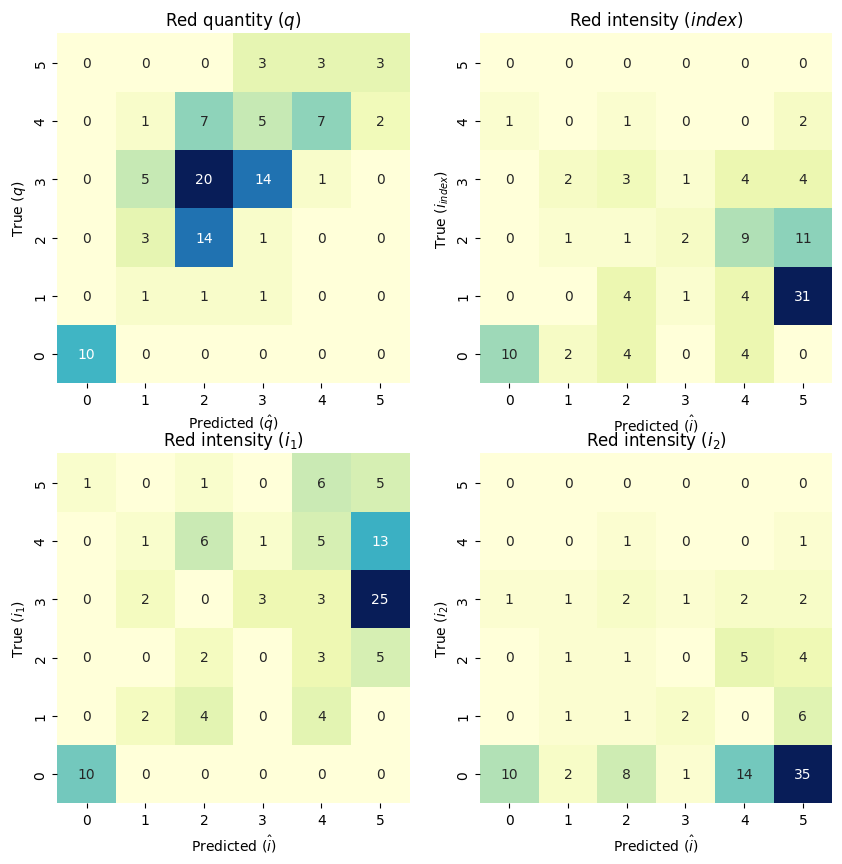

In [28]:
# from sckit
fig, axes = plt.subplots(2,2, figsize=(10,10))

# Pivot the table to have 'reference' as rows and 'predcctions' as columns
heatmap_data_quantity = contingency_table_quantity.pivot_table(index='q_ref', fill_value=0)
sns.heatmap(heatmap_data_quantity, annot=True, fmt="d", cmap="YlGnBu", ax=axes[0, 0], cbar=False)

heatmap_data_quality_1 = contingency_table_quality_1.pivot_table(index='i1_ref', fill_value=0)
sns.heatmap(heatmap_data_quality_1, annot=True, fmt="d", cmap="YlGnBu", ax=axes[1, 0], cbar=False)

heatmap_data_quality_2 = contingency_table_quality_2.pivot_table(index='i2_ref', fill_value=0)
sns.heatmap(heatmap_data_quality_2, annot=True, fmt="d", cmap="YlGnBu", ax=axes[1, 1], cbar=False)

heatmap_data_quality_index = contingency_table_quality_index.pivot_table(index='i_index_ref', fill_value=0)
sns.heatmap(heatmap_data_quality_index, annot=True, fmt="d", cmap="YlGnBu", ax=axes[0, 1], cbar=False)

# Set labels and title
axes[0, 0].set_ylabel('True ($q$)')
axes[0, 0].set_xlabel('Predicted ($\hat{q}$)')
axes[0, 0].set_title('Red quantity ($q$)')
axes[0, 0].set_ylim([0, 6])

axes[1, 0].set_ylabel('True ($i_1$)')
axes[1, 0].set_xlabel('Predicted ($\hat{i}$)')
axes[1, 0].set_title('Red intensity ($i_1$)')
axes[1, 0].set_ylim([0, 6])

axes[1, 1].set_ylabel('True ($i_2$)')
axes[1, 1].set_xlabel('Predicted ($\hat{i}$)')
axes[1, 1].set_title('Red intensity ($i_2$)')
axes[1, 1].set_ylim([0, 6])

axes[0, 1].set_ylabel('True ($i_{index}$)')
axes[0, 1].set_xlabel('Predicted ($\hat{i}$)')
axes[0, 1].set_title('Red intensity ($index$)')
axes[0, 1].set_ylim([0, 6])

# save the plot
images_dir = os.path.join(os.getcwd(), 'images')
plt.savefig(os.path.join(images_dir, 'confusion_mtxs_red_quantity_quality_Piani_et_al_2023_ISHS.png'), dpi=400)
plt.show()